In [41]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from re import split
from itertools import chain, starmap
from datetime import date
from collections import defaultdict
from pathlib import Path

# Bayesian MCMC analysis
import arviz as az
import pymc as pm
import bambi as bmb
import xarray

# Make project utils modules available.
sys.path.insert(0, str(Path().absolute().parents[0]))

from utils.dataUtils import (standardize, IQR, IQRQuartiles, roundHalfUp, mapRoundHalfUp, writeSummaryTables, 
                             createDataFramesFigures, returnWtAlphaTransitionPCRs, 
                             returnDeltaOmicronTransitionPCRs)
from utils.plotUtils import (annotateWithLetters, replaceLegend, ridgeForestPlot, setFontSize, 
                             spaghettiPlotCategorical, returnPlotDir,
                             plotFig1_A, plotFig1_B, plotFig1_C, plotFig1_D, plotFig2_A, plotFig2_B, 
                             plotFig3_A, plotFig3_B, plotFigA2_A, plotFigA2_B, plotFigA4_left, plotFigA4_right,
                             writeIDataSummaryTable)
from utils.plotParams import getPalettes, getLabels, getLegends, getOrders, getAbbrvsDict
from utils.regression import (SEED, logisticRegressionVars, logisticRegressionDf, sampleAgrdtSpec, 
                              sampleVl, predictionsNewData, returnIDataDir)

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
sns.set_theme(context="paper", 
              style="whitegrid",
              palette="deep", 
              font="sans-serif", 
              font_scale=1.5, 
              color_codes=True, 
              rc={"lines.linewidth": 0.9})
plt.rcParams.update({"font.size": 12})

# Load plotting parameters

In [7]:
pal = getPalettes()
legend = getLegends()
order = getOrders()
label = getLabels()
plotDir = returnPlotDir()
iDataDir = returnIDataDir()

In [8]:
abbrvDictPaper = getAbbrvsDict()

genderAbbrvs = abbrvDictPaper["gender"]
symptomAbbrvs = abbrvDictPaper["symptoms"]
variantAbbrvs = abbrvDictPaper["variant"]
immunAbbrvs = abbrvDictPaper["immun2YN"]
daysAbbrvs = abbrvDictPaper["binDaysPostOnset"]

In [9]:
cm = 1/2.54
colWidth = 3.54
fontSizePlot = 12
fontSizePlotSuppl = 10

In [10]:
colWidthAppendix = 10.7 * cm

# Load and preprocess data

## Ag-RDT data

In [11]:
pd.set_option('display.max_columns', 30)

In [49]:
# Load data
dataPath = Path("..", "data", "agrdtData.tsv")
df = pd.read_csv(dataPath, sep="\t", low_memory=False, parse_dates=['pcrDate'])
# Turn into datetime.date objects.
df["pcrDate"] = df["pcrDate"].apply(lambda pcrDate: pcrDate.date())

In [50]:
df.columns

Index(['pcrId', 'pcrDate', 'personHash', 'pcrPositive', 'vl', 'variant',
       'hasTyping', 'isFirstPosPcr', 'gender', 'age', 'symptoms',
       'daysPostOnset', 'binDaysPostOnset', 'recovered', 'immun2YN', 'immunYN',
       'immunN', 'immunNatLeast', 'vaccN', 'vaccNatLeast', 'surveyData',
       'agrdtYN', 'agrdt', 'testDevice', 'samplingMonth', 'samplingMonth2',
       'reasonPres', 'infectionKey', 'ill', 'fatigue', 'headache', 'vertigo',
       'melalgia', 'fever', 'cough', 'runnyNose', 'soreThroat', 'dyspnea',
       'noSmell', 'noTaste', 'nausea', 'noAppetite', 'vomiting', 'diarrhea'],
      dtype='object')

## Create data frames for figures.

In [13]:
dfTuple = createDataFramesFigures(df)
(dfAgrdt,
dfPos,
dfAllInd,
dfFigure1,
dfFigure1_A,
dfFigure1_B,
dfFigure1_C,
dfFigure2,
dfFigure2_A,
dfFigure2_B,
dfFigure3,
dfFigureA2) = dfTuple

### Counts (figures)

In [14]:
months2 = dfPos[dfPos.pcrDate > date(2020, 11, 30)].samplingMonth2.sort_values().unique()

countsPcr = [f"{((dfFigure2_B.samplingMonth2==month2) & (dfFigure2_B.agrdtYN==1)).sum()}"
             f"{(dfFigure2_B.samplingMonth2==month2).sum()}" for month2 in months2]
countsFigure1 = [f"n={(dfFigure1.samplingMonth2==month2).sum()}" for month2 in months2]
countsFigure1VaccInfoAvailable = [f"n={((dfFigure1.samplingMonth2==month2) & (dfFigure1.immunN.notna())).sum()}" for month2 in months2]

countsFigure2_A = [f"n={(dfFigure2_A.variant==variant).sum()}" for variant in order.variant]
countsFigure2_B = [f"No Agrdt: n={((dfFigure2.variant==variant) & (dfFigure2.agrdtYN==0)).sum()}, " 
                   f"Agrdt: n={((dfFigure2.variant==variant) & (dfFigure2.agrdtYN==1)).sum()}" 
                   for variant in order.variant]

countsFigure3_Asymp = [f"n={((dfFigure3.symptoms==0) & (dfFigure3.immun2YN==immun)).sum()}" for immun in order.immun2YN]
countsFigure3_Symp = [f"n={((dfFigure3.symptoms==1) & (dfFigure3.immun2YN==immun)).sum()}" for immun in order.immun2YN]

countsFigureA2_Asymp = [f"n={((dfFigureA2.symptoms==0) & (dfFigureA2.variant==variant)).sum()}" for variant in order.variant]
countsFigureA2_Symp = [f"n={((dfFigureA2.symptoms==1) & (dfFigureA2.variant==variant)).sum()}" for variant in order.variant]

In [15]:
countsFigure3Verbose_Asymp = [f"({immun}, {res}): {((dfFigure3.symptoms==0) & (dfFigure3.immun2YN==immun) & (dfFigure3.agrdt==res)).sum()}" for immun in order.immun2YN for res in (0, 1)]
countsFigure3Verbose_Symp = [f"({immun}, {res}): {((dfFigure3.symptoms==1) & (dfFigure3.immun2YN==immun) & (dfFigure3.agrdt==res)).sum()}" for immun in order.immun2YN for res in (0, 1)]

countsFigureA2Verbose_Asymp = [f"({variant}, {res}): {((dfFigureA2.symptoms==0) & (dfFigureA2.variant==variant) & (dfFigureA2.agrdt==res)).sum()}" for variant in order.variant for res in (0, 1)]
countsFigureA2Verbose_Symp = [f"({variant}, {res}): {((dfFigureA2.symptoms==1) & (dfFigureA2.variant==variant) & (dfFigureA2.agrdt==res)).sum()}" for variant in order.variant for res in (0, 1)]

In [16]:
pd.set_option("display.max_columns", 100)

# Exploring PCRs performed during variant transition times

In [17]:
dfWtAlphaTrans = returnWtAlphaTransitionPCRs(dfPos[dfPos.agrdt.notna()])
dfWtAlphaTransVariant = dfWtAlphaTrans[dfWtAlphaTrans.variant.notna()]

dfDeltaOmicronTrans = returnDeltaOmicronTransitionPCRs(dfPos[dfPos.agrdt.notna()])
dfDeltaOmicronTransVariant = dfDeltaOmicronTrans[dfDeltaOmicronTrans.variant.notna()]

In [18]:
print(dfWtAlphaTrans.vl.median() - dfWtAlphaTransVariant.vl.median())
print(dfWtAlphaTrans.vl.mean() - dfWtAlphaTransVariant.vl.mean())
print()
print(dfDeltaOmicronTrans.vl.median() - dfDeltaOmicronTransVariant.vl.median())
print(dfDeltaOmicronTrans.vl.mean() - dfDeltaOmicronTransVariant.vl.mean())

-0.15386096219999956
-0.21036695862572152

-0.4675006160999988
-0.4481400449017503


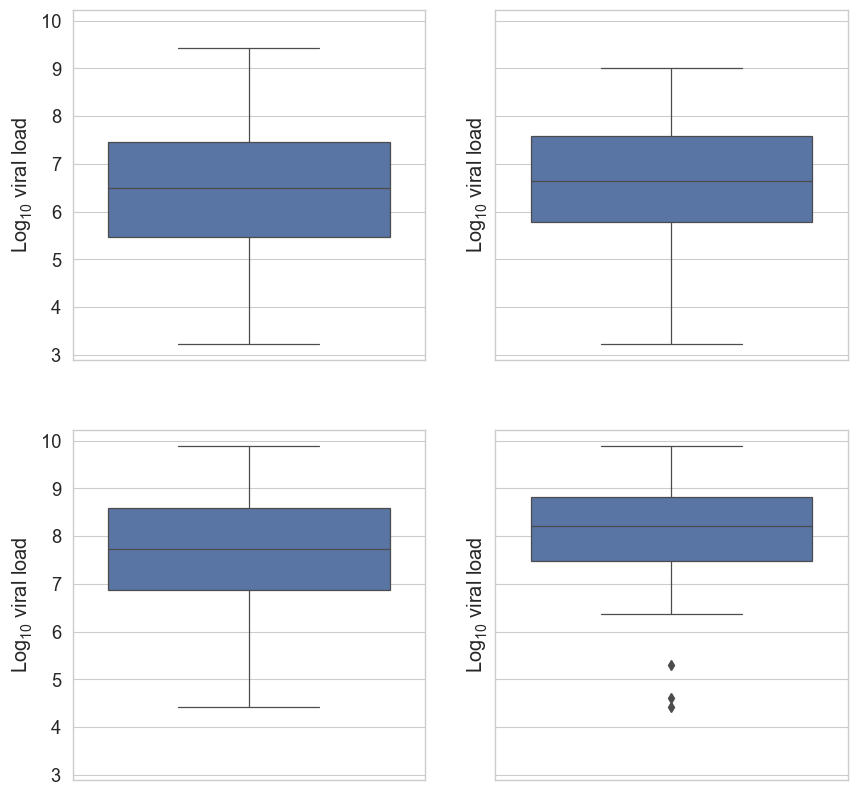

In [19]:
_, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
ax = ax.flatten()

sns.boxplot(data=dfWtAlphaTrans, y="vl", ax=ax[0])
sns.boxplot(data=dfWtAlphaTransVariant, y="vl", ax=ax[1])
sns.boxplot(data=dfDeltaOmicronTrans, y="vl", ax=ax[2])
sns.boxplot(data=dfDeltaOmicronTransVariant, y="vl", ax=ax[3])

for a in ax:
    a.set_ylabel(label.vl)

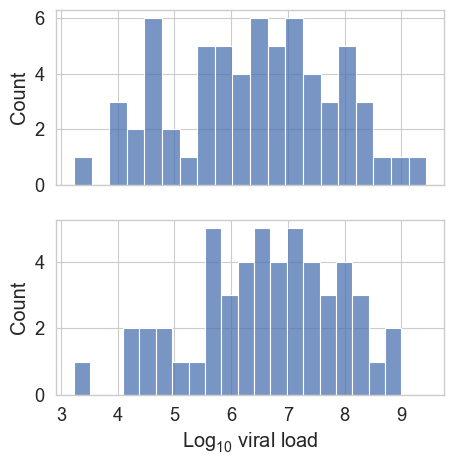

In [20]:
_, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
sns.histplot(dfWtAlphaTrans.vl, bins=20, ax=ax[0])
sns.histplot(dfWtAlphaTransVariant.vl, bins=20, ax=ax[1])

ax[1].set_xlabel(label.vl);

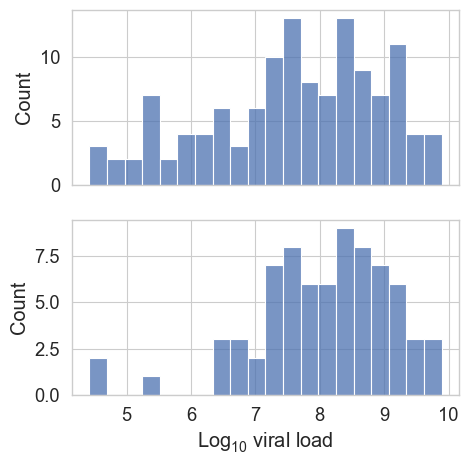

In [21]:
_, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
sns.histplot(dfDeltaOmicronTrans.vl, bins=20, ax=ax[0])
sns.histplot(dfDeltaOmicronTransVariant.vl, bins=20, ax=ax[1])

ax[1].set_xlabel(label.vl);

/Users/leoniemeiners/mambaforge/envs/sars-cov-2-agrdt-study/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/leoniemeiners/mambaforge/envs/sars-cov-2-agrdt-study/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


Text(0.5, 1.0, 'Samples with typing PCRs')

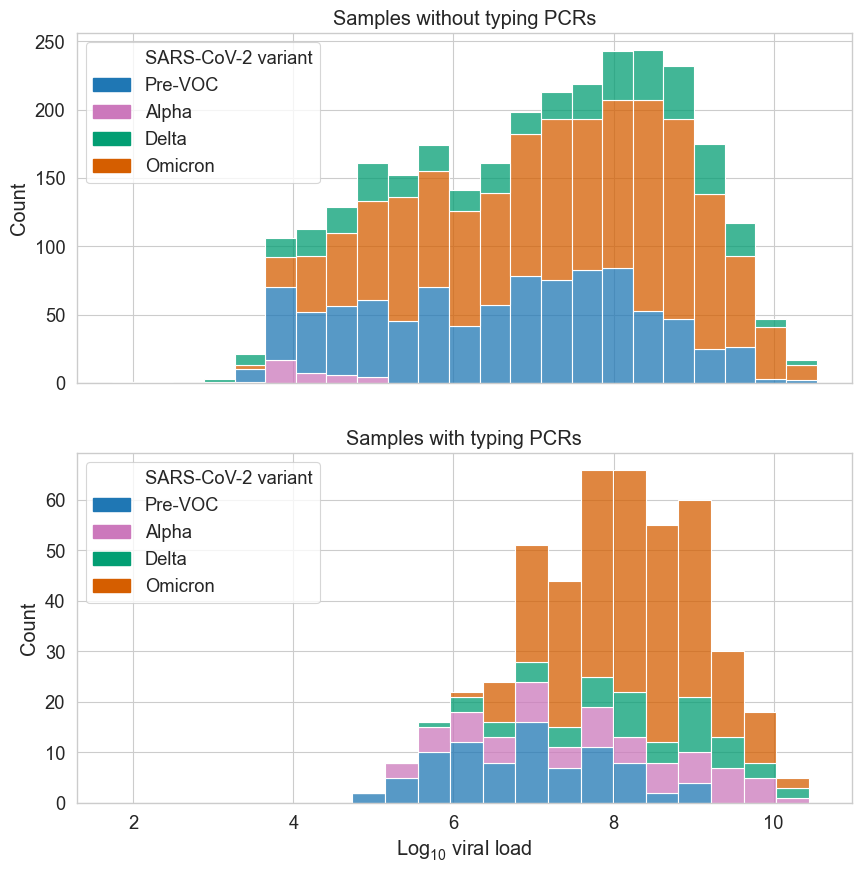

In [22]:
_, ax = plt.subplots(2, 1, figsize = (10, 10), sharex=True)

dfCurr = df[df.isFirstPosPcr==1]
sns.histplot(data=dfCurr[dfCurr.hasTyping==0], x="vl", hue="variant", multiple="stack", palette=pal.variant, ax=ax[0])
ax[0].set_xlabel(label.vl)
replaceLegend(ax[0], legend.variantPatch)

sns.histplot(data=dfCurr[dfCurr.hasTyping==1], x="vl", hue="variant", multiple="stack", palette=pal.variant, ax=ax[1])
ax[1].set_xlabel(label.vl)
ax[1].legend(handles=legend.variantPatch)
replaceLegend(ax[1], legend.variantPatch)

ax[0].set_title("Samples without typing PCRs")
ax[1].set_title("Samples with typing PCRs")

## Create summary tables

In [23]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [24]:
writeSummaryTables(dfAgrdt)

# Overall counts

In [16]:
print(f"Total number of Ag-RDTs performed: {len(dfAgrdt)}")
print(f"Total mumber of people tested by Ag-RDT: {dfAgrdt.personHash.nunique()}")
print()

print(f"Number of tests with questionnaire info: {(dfAgrdt.surveyData==1).sum()}")
print(f"Number of tests for which time post symptom onset was available: {(dfAgrdt.daysPostOnset.notna().sum())}")
print(f"Number of tests for which vaccination data is available: {dfAgrdt.vaccN.notna().sum()}")
print(f"Number of PCR positive tests with questionnaire info: {(dfPos.surveyData==1).sum()}")
print(f"Number of PCR positive tests for which vaccination data is available: {dfPos.vaccN.notna().sum()}")
print()

print(f"Number of tests where person was symptomatic: {(dfAgrdt.symptoms == 1).sum()}")
print(f"Number of tests where person was asymptomatic: {(dfAgrdt.symptoms == 0).sum()}")
print(f"Percentage of symptomatic people: {dfAgrdt.symptoms.mean():.2f}")
print(f"Number of tested asymptomatic people: {dfAgrdt[dfAgrdt.symptoms == 0].personHash.nunique()}")
print(f"Number of tested symptomatic people: {dfAgrdt[dfAgrdt.symptoms == 1].personHash.nunique()}")
print()

print(f"Number of positive PCRs: {(dfAgrdt.pcrPositive).sum()}")
print(f"Number of positive PCRs (where symptom status is known): {(dfAgrdt.symptoms.notna() & dfAgrdt.pcrPositive).sum()}")
print(f"Number of tests with known symptom status and PCR result: {(dfAgrdt.symptoms.notna() & dfAgrdt.pcrPositive.notna()).sum()}")
print()

print(f"Number of positive Ag-RDTs: {(dfAgrdt.agrdt).sum()}")
print(f"Number of positive Ag-RDTs (where symptom status is known): {(dfAgrdt.symptoms.notna() & dfAgrdt.agrdt).sum()}")
print(f"Number of tests with known symptom status and Ag-RDT result: {(dfAgrdt.symptoms.notna() & dfAgrdt.agrdt.notna()).sum()}")
print()

# Note: we are considering all tests, irrespective of known or unknown symptom status
print(f"Fraction of typed PCRs (only tests with corresponding rapid test): {(dfAgrdt.pcrPositive & (dfAgrdt.hasTyping == 1) & dfAgrdt.variant.notna()).sum()/(dfAgrdt.pcrPositive & dfAgrdt.agrdt.notna()).sum():.3f}")
print(f"Number of typed PCRs (only tests with corresponding rapid test): {(dfAgrdt.pcrPositive & (dfAgrdt.hasTyping == 1) & dfAgrdt.variant.notna()).sum()}")
print(f"Fraction of typed PCRs (all tests): {df.hasTyping.mean():.2f}")
infectionsWithTypingPCR = df[df.hasTyping == 1].infectionKey
maskPcrNoTyping = dfAgrdt.pcrPositive & dfAgrdt.variant.notna() & ((dfAgrdt.hasTyping == 0) | dfAgrdt.hasTyping.isna())
print(f"Number of PCRs where variant was assigned because typed PCR is in the same infection: {(maskPcrNoTyping & dfAgrdt.infectionKey.isin(infectionsWithTypingPCR)).sum()}")
print(f"Number of PCRs were variant was assigned by date: {(maskPcrNoTyping & ~dfAgrdt.infectionKey.isin(infectionsWithTypingPCR)).sum():.2f}")
print()

print(f"Number of positive PCRs for which we know the person had a prior infection: {dfPos.recovered.sum():.2f}")
print(f"Fraction of positive PCRs for which we know the person had a prior infection: {dfPos.recovered.mean():.2f}")
print()

dfRecovered = dfPos[dfPos.recovered==1]
print(f"Number of positive PCRs for which the person had at least two infections (and no vaccinations): {((dfRecovered.vaccN==0) & (dfRecovered.immunN >= 2)).sum():.2f}")
print(f"Fraction of positive PCRs for which we know the person had a prior infection and at least one vaccination: {(dfRecovered.vaccNatLeast > 0).mean():.2f}")
print(f"Fraction of positive PCRs for which we know the person had a prior infection and at least one vaccination: {(dfRecovered.vaccNatLeast > 0).sum():.2f}")
print()

print(f"Ratio of PCR positive people for whom we know vaccination/recovery status: "
      f"{dfPos.immunN.notna().sum()/len(dfPos):.2f}")
print(f"Ratio of PCR positive people for whom we know vaccination/recovery status (of those referred to in Figure 1): "
      f"{dfFigure1_A.immunN.notna().sum()/len(dfFigure1_A):.2f}")
print(f"Ratio of people for whom we know vaccination/recovery status (immun2YN): {dfPos.immun2YN.notna().sum()/len(dfPos):.2f}")
print(f"Fraction of immunized (at least once) people that had a prior vaccination (as opposed to a prior infection): {1 - dfPos[dfPos.immunYN == 1].recovered.mean():.2f}")
print(f"Count of immunized (at least once) people that had a prior vaccination (as opposed to a prior infection): {(dfPos.immunYN == 1).sum() - ((dfPos.immunYN == 1) & (dfPos.recovered == 1)).sum()}")
print()

# Note: we're using Figure1_A here to keep the people that had 4 immunizations.
print(f"Number of tests/tested employees with known number of immunizations in Dec 20/Jan 21: {(dfFigure1_A.immunN.notna() & (dfFigure1_A.samplingMonth2 == 0)).sum()}")
print(f"Number of tests/tested employees with at least two immunizations in Dec 20/Jan 21: {((dfFigure1_A.samplingMonth2 == 0) & dfFigure1_A.immun2YN).sum()}")
print()


print(f"Number of tests/tested employees with known number of immunizations in Oct 21/Nov 21: {(dfFigure1_A.immunN.notna() & (dfFigure1_A.samplingMonth2 == 5)).sum()}")
print(f"Number of tests/tested employees with at least two immunizations in Oct 21/Nov 21: {((dfFigure1_A.samplingMonth2 == 5) & dfFigure1_A.immun2YN).sum()}")
print()

# Note: we don't know the exact number of vaccinations for all employees, but for some we know the minimum number (these are considered in 
# columns "immunNatLeast" and "immun2YN").Therefore, the given fractions are lower bounds.
dfDec21Jan22 = dfFigure1_A[dfFigure1_A.samplingMonth2 == 6]
print(f"Fraction (lower bound) of employees with third vaccination in Dec 21/Jan 22: {(dfDec21Jan22.immunNatLeast >= 3).sum()/len(dfDec21Jan22):.2f}")
dfWtAlpha = dfFigure1_A[dfFigure1_A.samplingMonth2 < 4]
dfDeltaOmicron = dfFigure1_A[dfFigure1_A.samplingMonth2 >= 4]

print(f"Number of employees with at least two immunizations during wildtype/alpha waves: {(dfWtAlpha.immun2YN).sum()}")
print(f"Fraction (lower bound) of employees with at least two immunizations during wildtype/alpha waves: {(dfWtAlpha.immun2YN).sum()/len(dfWtAlpha):.2f}")
print(f"Fraction (lower bound) of employees with at least two immunizations during delta/omicron waves: {(dfDeltaOmicron.immun2YN).sum()/len(dfDeltaOmicron):.2f}")
print(f"Fraction (upper bound) of employees with at least two immunizations during delta/omicron waves: {(dfDeltaOmicron.immun2YN).sum()/(dfDeltaOmicron.immunN.notna()).sum():.2f}")

Total number of Ag-RDTs performed: 14773
Total mumber of people tested by Ag-RDT: 7675

Number of tests with questionnaire info: 5618
Number of tests for which time post symptom onset was available: 4503
Number of tests for which vaccination data is available: 11011
Number of PCR positive tests with questionnaire info: 742
Number of PCR positive tests for which vaccination data is available: 1441

Number of tests where person was symptomatic: 8371
Number of tests where person was asymptomatic: 5915
Percentage of symptomatic people: 0.59
Number of tested asymptomatic people: 3190
Number of tested symptomatic people: 5583

Number of positive PCRs: 1600
Number of positive PCRs (where symptom status is known): 1534
Number of tests with known symptom status and PCR result: 14286

Number of positive Ag-RDTs: 905.0
Number of positive Ag-RDTs (where symptom status is known): 881
Number of tests with known symptom status and Ag-RDT result: 14286

Fraction of typed PCRs (only tests with correspo

# Descriptive plots

## Figure 1

### Labels

In [43]:
month2Labels = list(abbrvDictPaper["samplingMonth2"].values())

months2 = dfPos[dfPos.pcrDate > date(2020, 11, 30)].samplingMonth2.sort_values().unique()
month2ToMonths = {monthBin: label for monthBin, label in zip(months2, month2Labels)}

In [44]:
statsDictTime = defaultdict(lambda: defaultdict(dict))

### Subplots

#### Subplot A

Modeling the probability that agrdt==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|samplingMonth2_sigma, 1|samplingMonth2_offset]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 104 seconds.
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:854: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(map(int, labelsPercent)))
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1388: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(list(range(0, 101, 20)))


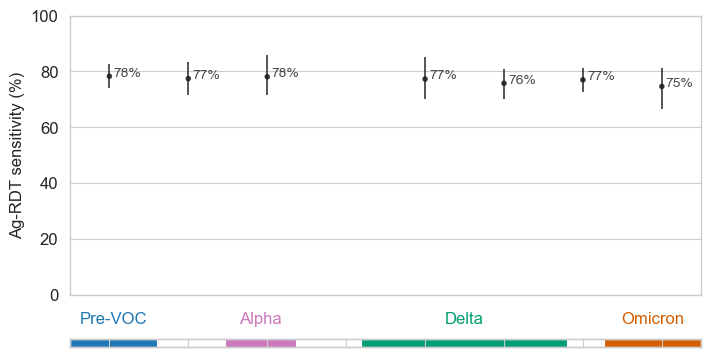

In [26]:
_, ax = plt.subplots(2, 1, figsize=(colWidth*2, colWidth), gridspec_kw={"height_ratios": [1, 0.03]})
model, iData = plotFig1_A(dfFigure1_A, dfPos, statsDictTime, order, label=label, palette=pal, 
                          abbrvDictPaper=abbrvDictPaper, ax=ax, fontSizePlot=fontSizePlot)
plt.savefig(f"{plotDir}/Figure1-A.pdf", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure1-A.png", dpi=600, bbox_inches="tight")

#### Subplot B

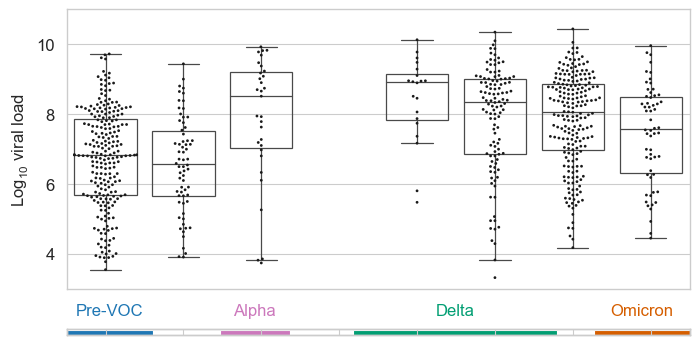

In [27]:
_, ax = plt.subplots(2, 1, figsize=(colWidth*2, colWidth), gridspec_kw={"height_ratios": [1, 0.02]})
plotFig1_B(dfFigure1_B, dfPos, timeVar="samplingMonth2", xOrder=month2ToMonths, palette=pal, label=label, 
           abbrvDictPaper=abbrvDictPaper, ax=ax, fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/Figure1-B.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure1-B.pdf", dpi=600, bbox_inches="tight")

In [32]:
print("Viral load medians\n")
for idxMonth2, vlMedian in dfFigure1_B.groupby(by=["samplingMonth2"]).vl.agg("median").items():
    print(f"{month2ToMonths[idxMonth2]}: {roundHalfUp(vlMedian)}")

Viral load medians

Dec '20 - Jan '21: 6.83
Feb '21 - March '21: 6.56
April '21 - May '21: 8.51
Aug '21 - Sep '21: 8.91
Oct '21 - Nov '21: 8.34
Dec '21 - Jan '22: 8.05
Feb '22: 7.57


In [19]:
print("Viral load IQRs\n")
for idxMonth2, vlIQR in dfFigure1_B.groupby(by=["samplingMonth2"]).vl.agg(IQR).items():
    print(f"{month2ToMonths[idxMonth2]}: {roundHalfUp(vlIQR)}")

Viral load IQRs

Dec '20 - Jan '21: 2.16
Feb '21 - March '21: 1.85
April '21 - May '21: 2.17
Aug '21 - Sep '21: 1.31
Oct '21 - Nov '21: 2.12
Dec '21 - Jan '22: 1.89
Feb '22: 2.2


In [25]:
print("Viral load IQRs (Q1, Q3)\n")
for idxMonth2, (Q1, Q3) in dfFigure1_B.groupby(by=["samplingMonth2"]).vl.agg(IQRQuartiles).items():
    print(f"{month2ToMonths[idxMonth2]}: {roundHalfUp(Q1), roundHalfUp(Q3)}")

Viral load IQRs (Q1, Q3)

Dec '20 - Jan '21: (5.69, 7.85)
Feb '21 - March '21: (5.66, 7.51)
April '21 - May '21: (7.04, 9.2)
Aug '21 - Sep '21: (7.84, 9.15)
Oct '21 - Nov '21: (6.87, 8.99)
Dec '21 - Jan '22: (6.96, 8.85)
Feb '22: (6.3, 8.5)


In [34]:
print(f"Number of tests")
for timePeriod, nTests in zip(month2ToMonths.values(), countsFigure1):
    print(f"{timePeriod}: {nTests}")

Number of tests
Dec '20 - Jan '21: n=228
Feb '21 - March '21: n=66
April '21 - May '21: n=31
June '21 - July '21: n=1
Aug '21 - Sep '21: n=20
Oct '21 - Nov '21: n=114
Dec '21 - Jan '22: n=207
Feb '22: n=58


In [159]:
print(f"Number of tests with vaccination/prior infection info available")
for timePeriod, nTests in zip(month2ToMonths.values(), countsFigure1VaccInfoAvailable):
    print(f"{timePeriod}: {nTests}")

Number of tests with vaccination/prior infection info available
Dec '20 - Jan '21: n=219
Feb '21 - March '21: n=57
April '21 - May '21: n=28
June '21 - July '21: n=1
Aug '21 - Sep '21: n=20
Oct '21 - Nov '21: n=110
Dec '21 - Jan '22: n=194
Feb '22: n=50


#### Subplot C

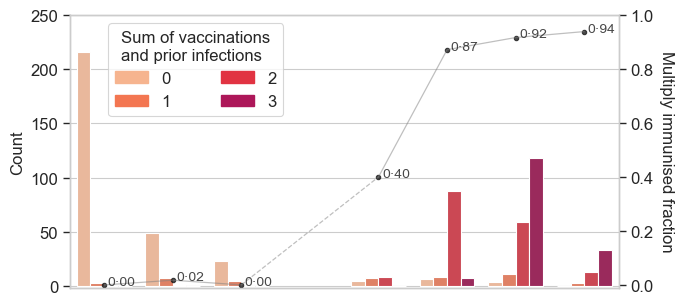

In [28]:
_, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth))

plotFig1_C(dfFigure1_C, timeVar="samplingMonth2", xOrder=order.samplingMonth2, palette=pal, label=label,
           legend=legend, ax=ax, legendLoc=(0.07, 0.63), fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/Figure1-C.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure1-C.pdf", dpi=600, bbox_inches="tight")

In [29]:
print(f"Fraction of people for whom exact number of prior vaccinations/infections is known: {(dfFigure1_A.immunN.notna()).sum()/len(dfFigure1_A):.2f}")

Fraction of people for whom exact number of prior vaccinations/infections is known: 0.94


#### Subplot D

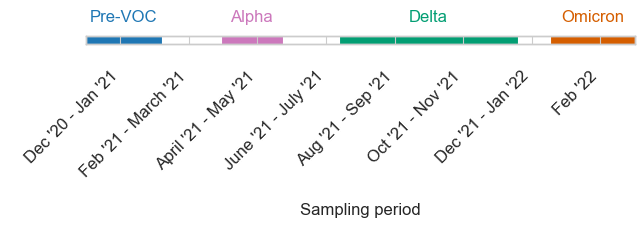

In [30]:
_, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth * 0.03))
plotFig1_D(dfPos, timeVar="samplingMonth2", palette=pal, labels=month2Labels, abbrvDictPaper=abbrvDictPaper, 
           fontSizePlot=fontSizePlot, ax=ax)

plt.savefig(f"{plotDir}/Figure1-D.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure1-D.pdf", dpi=600, bbox_inches="tight")

### Complete plot

/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:854: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(map(int, labelsPercent)))
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1388: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(list(range(0, 101, 20)))


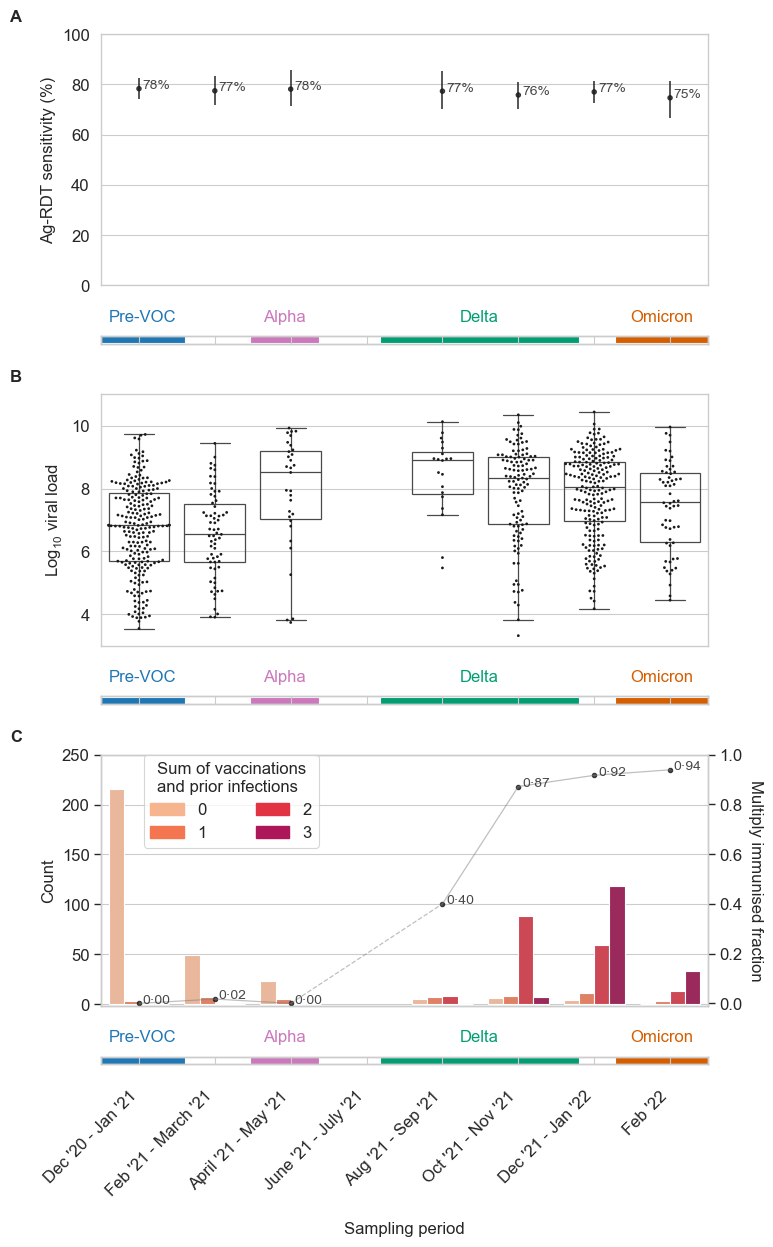

In [31]:
fig, ax = plt.subplots(6, 1, figsize = (colWidth*2, colWidth*3.09), gridspec_kw={"height_ratios": [1, 0.03, 1, 0.03, 1, 0.03]})

plotFig1_A(dfFigure1_A, dfPos, statsDictTime, order, label=label, palette=pal, 
           abbrvDictPaper=abbrvDictPaper, ax=ax[:2], fontSizePlot=fontSizePlot)
plotFig1_B(dfFigure1_B, dfPos, timeVar="samplingMonth2", xOrder=month2ToMonths, palette=pal, label=label, 
           abbrvDictPaper=abbrvDictPaper, ax=ax[2:4], fontSizePlot=fontSizePlot)
plotFig1_C(dfFigure1_C, timeVar="samplingMonth2", xOrder=order.samplingMonth2, palette=pal, label=label,
           legend=legend, ax=ax[4], legendLoc=(0.07, 0.63), fontSizePlot=fontSizePlot)
plotFig1_D(dfPos, timeVar="samplingMonth2", palette=pal, labels=month2Labels, abbrvDictPaper=abbrvDictPaper, 
           fontSizePlot=fontSizePlot, ax=ax[5])

annotateWithLetters((ax[0], ax[2], ax[4]), coords=(-0.15, 1.05), size=fontSizePlot)

plt.savefig(f"{plotDir}/Figure1.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure1.pdf", dpi=600, bbox_inches="tight")

In [39]:
print(f"Difference in viral load medians between Dec 20 - Jan 21 and Feb 22: "
      f"{dfFigure1_A[dfFigure1_A.samplingMonth2 == 7].vl.median() - dfFigure1_A[dfFigure1_A.samplingMonth2 == 0].vl.median():.2f}")

Difference in viral load medians between Dec 20 - Jan 21 and Feb 22: 0.74


In [40]:
print(f"Number of SARS-CoV-2 positive symptomatic people (first positive PCR) who got an antigen test: "
      f"{(dfFigure1_A.agrdtYN==1).sum()}")

Number of SARS-CoV-2 positive symptomatic people (first positive PCR) who got an antigen test: 724


## Figure 2

### Subplots

#### Subplot A

/Users/leoniemeiners/virology/projects/agrdt-study/utils/dataUtils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, jitterCol] = df[origCol] + np.random.randn(len(df[origCol])) * stdev


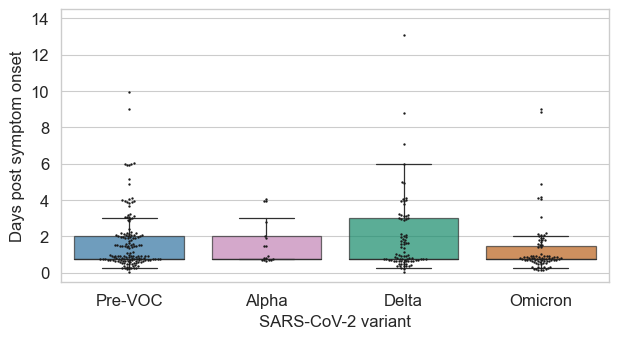

In [17]:
_, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth))
plotFig2_A(dfFigure2_A, label=label, palette=pal, abbrvDictPaper=abbrvDictPaper, ax=ax, fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/Figure2-A.pdf", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure2-A.png", dpi=600, bbox_inches="tight")

In [187]:
print(f"Counts per variant: {', '.join(countsFigure2_A)}")

Counts per variant: n=150, n=17, n=83, n=81


#### Subplot B

/Users/leoniemeiners/miniconda3/envs/agrdt-study/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


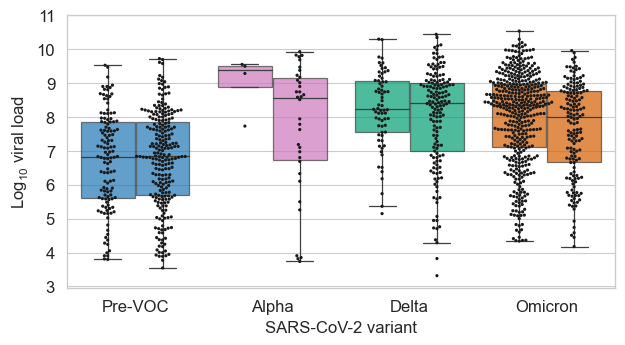

In [19]:
_, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth))
plotFig2_B(dfFigure2_B, palette=pal, label=label, order=order, abbrvDictPaper=abbrvDictPaper, 
           ax=ax, fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/Figure2-B.pdf", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure2-B.png", dpi=600, bbox_inches="tight")

In [186]:
for counts, variant in zip(countsFigure2_B, variantAbbrvs.values()):
    print(f"{variant}: {counts}")

Pre-VOC: No Agrdt: n=124, Agrdt: n=236
Alpha: No Agrdt: n=4, Agrdt: n=34
Delta: No Agrdt: n=67, Agrdt: n=153
Omicron: No Agrdt: n=425, Agrdt: n=157


### Complete plot

/Users/leoniemeiners/virology/projects/agrdt-study/utils/dataUtils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, jitterCol] = df[origCol] + np.random.randn(len(df[origCol])) * stdev
/Users/leoniemeiners/miniconda3/envs/agrdt-study/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


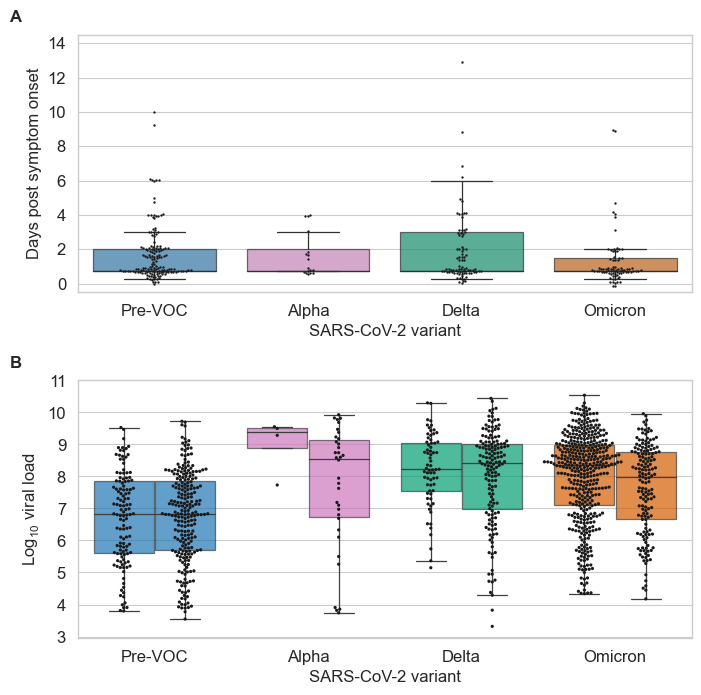

In [22]:
_, ax = plt.subplots(2, 1, figsize=(colWidth*2, colWidth*2))
ax1, ax2 = ax.flatten()

plotFig2_A(dfFigure2_A, label=label, palette=pal, abbrvDictPaper=abbrvDictPaper, ax=ax1, 
           fontSizePlot=fontSizePlot)
plotFig2_B(dfFigure2_B, palette=pal, label=label, order=order, abbrvDictPaper=abbrvDictPaper, 
           ax=ax2, fontSizePlot=fontSizePlot)

annotateWithLetters(ax, size=fontSizePlot, coords=(-0.11, 1.05))

plt.tight_layout(pad=1)

plt.savefig(f"{plotDir}/Figure2.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure2.pdf", dpi=600, bbox_inches="tight")

## Figure 3

In [23]:
statsDictFigure3 = defaultdict(lambda: defaultdict(dict))

In [24]:
def combineToStrImmunSymp(row):
    try:
        return f"{int(row.immun2YN)}, {int(row.symptoms)}"
    except ValueError:
        return np.nan
    
# Create a new column indicating whether people had symptoms and whether they were immunized.
dfFigure3["immun2YN:symptoms"] = dfFigure3.apply(combineToStrImmunSymp, axis=1)

In [39]:
# This is to indicate the immunization status. The dummy entry is there just to have a gap between 
# asymptomatic and symptomatic people in the plot.
immunSympDict = {
    "0, 0": "no",
    "1, 0": "yes",
    "dummy": "",
    "0, 1": "no",
    "1, 1": "yes",
}
# This is to indicate the symptom status
immunSympPal = dict(zip(immunSympDict, list(pal.immun2YN.values()) + ["k"] +  list(pal.immun2YN.values())))

### Subplots

#### Subplot A

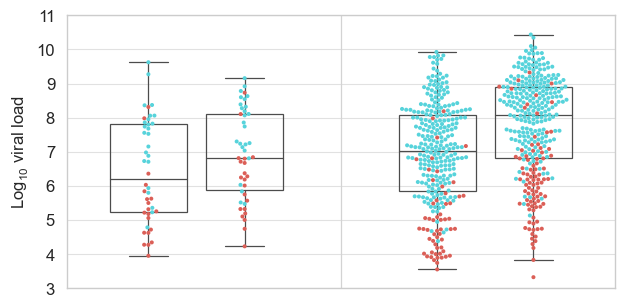

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth*1))
plotFig3_A(dfFigure3, immunSympDict, palette=pal, order=order, label=label, ax=ax, fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/Figure3-A.pdf", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure3-A.png", dpi=600, bbox_inches="tight")

In [26]:
print("Viral load medians (Q1, Q3)")
medianDictFig3 = dict(dfFigure3[dfFigure3.symptoms==1].groupby("immun2YN").vl.median().items())
iqrsDictFig3 = dict(dfFigure3[dfFigure3.symptoms==1].groupby("immun2YN").vl.apply(IQR))
iqrsDict2Fig3 = dict(dfFigure3[dfFigure3.symptoms==1].groupby("immun2YN").vl.apply(IQRQuartiles))

# print(f"Not multiply-immunized: {medianDictFig3[0]:.2f} ({iqrsDictFig3[0]:.2f})")
# print(f"Multiply-immunized: {medianDictFig3[1]:.2f} ({iqrsDictFig3[1]:.2f})")

print(f"Not multiply-immunized: {medianDictFig3[0]:.2f} ({iqrsDict2Fig3[0][0]:.2f}, {iqrsDict2Fig3[0][1]:.2f})")
print(f"Multiply-immunized: {medianDictFig3[1]:.2f} ({iqrsDict2Fig3[1][0]:.2f}, {iqrsDict2Fig3[1][1]:.2f})")

Viral load medians (Q1, Q3)
Not multiply-immunized: 7.02 (5.83, 8.07)
Multiply-immunized: 8.08 (6.80, 8.89)


#### Subplot B

Modeling the probability that agrdt==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [immun2YN:symptoms]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 31 seconds.
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:838: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(map(int, labelsPercent)))
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1668: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(range(0, 101, 20)))


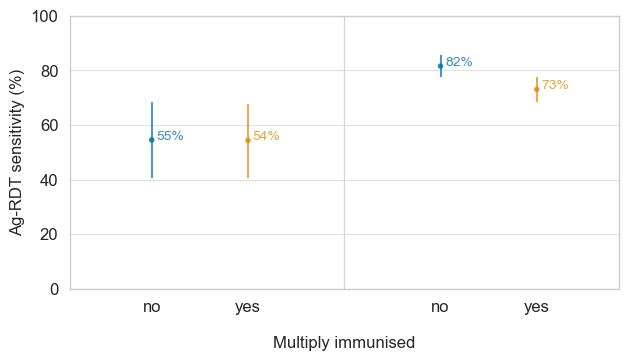

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth*1))
_, _ = plotFig3_B(dfFigure3, statsDictFigure3, immunSympDict, immunSympPalette=immunSympPal, label=label,
                  ax=ax, fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/Figure3-B.pdf", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure3-B.png", dpi=600, bbox_inches="tight")

In [50]:
sympImmuneNaiveMean = statsDictFigure3["immun2YN:symptoms"]["0, 1"]["mean"]
sympImmuneNaiveHdi = statsDictFigure3["immun2YN:symptoms"]["0, 1"]["hdi"]

sympImmunizedMean = statsDictFigure3["immun2YN:symptoms"]["1, 1"]["mean"]
sympImmunizedHdi = statsDictFigure3["immun2YN:symptoms"]["1, 1"]["hdi"]

print("Ag-RDT sensitivity for symptomatic people:")
print(f"Immune naive: {roundHalfUp(sympImmuneNaiveMean)}, {list(map(roundHalfUp, sympImmuneNaiveHdi))}")
print(f"Immunized: {roundHalfUp(sympImmunizedMean)}, {list(map(roundHalfUp, sympImmunizedHdi))}")

Ag-RDT sensitivity for symptomatic people:
Immune naive: 0.82, [0.78, 0.86]
Immunized: 0.73, [0.68, 0.78]


### Complete plot

/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:838: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(map(int, labelsPercent)))
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1668: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(range(0, 101, 20)))


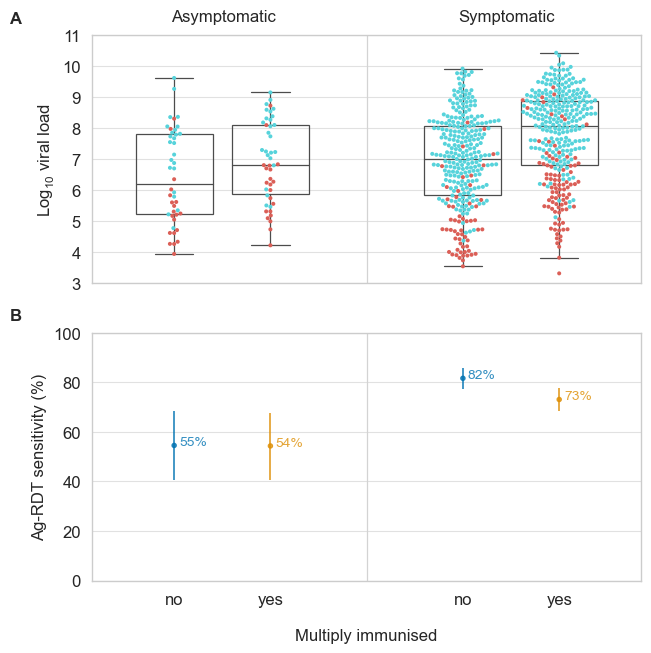

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(colWidth*2, colWidth*2))
ax1, ax2 = ax

plotFig3_A(dfFigure3, immunSympDict, palette=pal, order=order, label=label, ax=ax1, fontSizePlot=fontSizePlot)
_, _ = plotFig3_B(dfFigure3, statsDictFigure3, immunSympDict, immunSympPalette=immunSympPal, label=label,
                  ax=ax2, fontSizePlot=fontSizePlot)

fig.text(0.31, 0.9, "Asymptomatic", ha="center", fontdict={"fontsize": fontSizePlot})
fig.text(0.71, 0.9, "Symptomatic", ha="center", fontdict={"fontsize": fontSizePlot})

annotateWithLetters(ax, size=fontSizePlot, coords=(-0.15, 1.05))

plt.savefig(f"{plotDir}/Figure3.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure3.pdf", dpi=600, bbox_inches="tight")

In [52]:
diffImmunAsymp = statsDictFigure3["immun2YN:symptoms"]["0, 0"]["samples"] - statsDictFigure3["immun2YN:symptoms"]["1, 0"]["samples"]
diffImmunSymp = statsDictFigure3["immun2YN:symptoms"]["0, 1"]["samples"] - statsDictFigure3["immun2YN:symptoms"]["1, 1"]["samples"]

immunAsympMean = np.mean(diffImmunAsymp)
immunAsympHdi = az.hdi(diffImmunAsymp, 0.94)
immunSympMean = np.mean(diffImmunSymp)
immunSympHdi = az.hdi(diffImmunSymp, 0.94)

In [374]:
print("Mean sensitivity differences (HPDIs) between immune naive and multiply-immunized people")
print(f"Asymptomatics: {immunAsympMean:.4f} ({mapRoundHalfUp(immunAsympHdi, 4)})")
print(f"Symptomatics: {immunSympMean:.4f} ({mapRoundHalfUp(immunSympHdi, 4)})")

Mean sensitivity differences (HPDIs) between immune naive and multiply-immunized people
Asymptomatics: 0.0020 ([-0.1887, 0.201])
Symptomatics: 0.0856 ([0.024, 0.148])


In [398]:
print("Number of tests/employees (immune naive, multiply-immunized)")
print(f"Asymptomatics: {', '.join(countsFigure3_Asymp)}")
print(f"Symptomatics: {', '.join(countsFigure3_Symp)}")

Number of tests/employees (immune naive, multiply-immunized)
Asymptomatics: n=44, n=46
Symptomatics: n=305, n=331


In [392]:
print("Counts of negative and positive Ag-RDTs")
print()
print("Asymptomatic people")
print(f"Immune naive (neg, pos): {countsFigure3Verbose_Asymp[0].split(':')[1]}, {countsFigure3Verbose_Asymp[1].split(':')[1]}")
print(f"Multiply immunized (neg, pos): {countsFigure3Verbose_Asymp[2].split(':')[1]}, {countsFigure3Verbose_Asymp[3].split(':')[1]}")

print()
print("Symptomatic people")
print(f"Immune naive (neg, pos): {countsFigure3Verbose_Symp[0].split(':')[1]}, {countsFigure3Verbose_Symp[1].split(':')[1]}")
print(f"Multiply immunized (neg, pos): {countsFigure3Verbose_Symp[2].split(':')[1]}, {countsFigure3Verbose_Symp[3].split(':')[1]}")

Counts of negative and positive Ag-RDTs

Asymptomatic people
Immune naive (neg, pos):  20,  24
Multiply immunized (neg, pos):  21,  25

Symptomatic people
Immune naive (neg, pos):  56,  249
Multiply immunized (neg, pos):  90,  241


## Figure A2

In [25]:
def combineToStrSymp(row):
    try:
        return f"{(row.variant)}, {int(row.symptoms)}"
    except ValueError:
        return np.nan

In [26]:
# This is only to indicate the variant. The dummy entry is there only to have a gap between asymptomatic
# and symptomatic people in the plot.
variantSympDict = {
    "wildtype, 0": abbrvDictPaper["variant"]["wildtype"],
    "alpha, 0": abbrvDictPaper["variant"]["alpha"],
    "delta, 0": abbrvDictPaper["variant"]["delta"],
    "omicron, 0": abbrvDictPaper["variant"]["omicron"],
    "dummy": "",
    "wildtype, 1": abbrvDictPaper["variant"]["wildtype"],
    "alpha, 1": abbrvDictPaper["variant"]["alpha"],
    "delta, 1": abbrvDictPaper["variant"]["delta"],
    "omicron, 1": abbrvDictPaper["variant"]["omicron"],
}
# This is to indicate the symptom status
variantSympPal = dict(zip(variantSympDict, list(pal.variant.values()) + ["k"] + list(pal.variant.values())))

### Subplots

In [27]:
# Create a new column indicating whether people had symptoms and which variant they had.
dfFigureA2["variant:symptoms"] = dfFigureA2.apply(combineToStrSymp, axis=1)

#### Subplot A

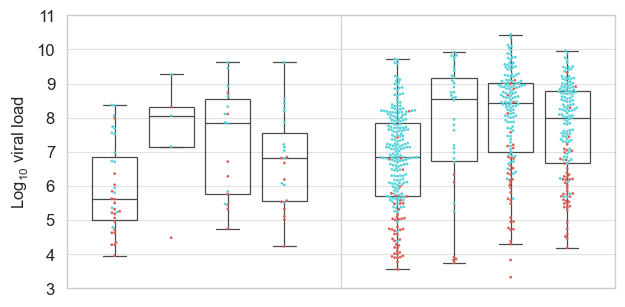

In [28]:
_, ax = plt.subplots(1, 1, figsize=(colWidth * 2, colWidth))
plotFigA2_A(dfFigureA2, variantSympDict, label, palette=pal, order=order, ax=ax, fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/FigureA2-A.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA2-A.pdf", dpi=600, bbox_inches="tight")

In [29]:
print("Viral load medians (Q1, Q3) in symptomatic people\n")
dfFigureA2Symp = dfFigureA2[dfFigureA2.symptoms == 1]
medianDictFigA2 = dict(dfFigureA2Symp.groupby(by=["variant"]).vl.agg("median").items())
iqrDictFigA2 = dict(dfFigureA2Symp.groupby(by=["variant"]).vl.agg(IQRQuartiles).items())

for variantAbbrv, variant in variantAbbrvs.items():
    print(f"{variant}: {roundHalfUp(medianDictFigA2[variantAbbrv])} ({roundHalfUp(iqrDictFigA2[variantAbbrv][0])}, {roundHalfUp(iqrDictFigA2[variantAbbrv][1])})")

Viral load medians (Q1, Q3) in symptomatic people

Pre-VOC: 6.84 (5.69, 7.83)
Alpha: 8.55 (6.72, 9.15)
Delta: 8.42 (7.0, 9.02)
Omicron: 7.99 (6.66, 8.77)


#### Subplot B

Modeling the probability that agrdt==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variant:symptoms]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 32 seconds.
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:854: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(map(int, labelsPercent)))
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1797: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(range(0, 101, 20)))


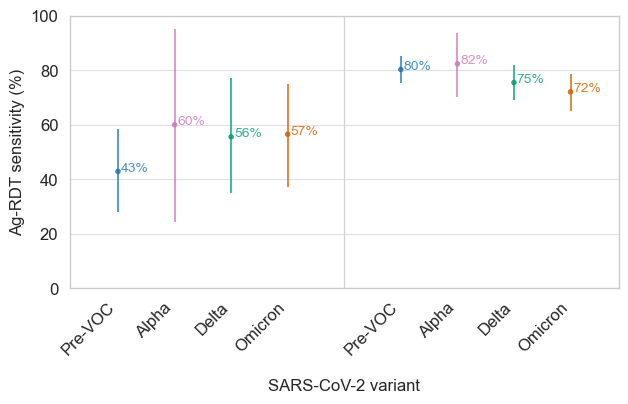

In [30]:
_, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth))
_, _ = plotFigA2_B(dfFigureA2, statsDictFigure3, variantSympDict, variantSympPalette=variantSympPal,
                   label=label, ax=ax, fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/FigureA2-B.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA2-B.pdf", dpi=600, bbox_inches="tight")

In [31]:
sympWtMean = statsDictFigure3["variant:symptoms"]["wildtype, 1"]["mean"]
sympWtHdi = statsDictFigure3["variant:symptoms"]["wildtype, 1"]["hdi"]

sympAlphaMean = statsDictFigure3["variant:symptoms"]["alpha, 1"]["mean"]
sympAlphaHdi = statsDictFigure3["variant:symptoms"]["alpha, 1"]["hdi"]

sympDeltaMean = statsDictFigure3["variant:symptoms"]["delta, 1"]["mean"]
sympDeltaHdi = statsDictFigure3["variant:symptoms"]["delta, 1"]["hdi"]

sympOmicronMean = statsDictFigure3["variant:symptoms"]["omicron, 1"]["mean"]
sympOmicronHdi = statsDictFigure3["variant:symptoms"]["omicron, 1"]["hdi"]

print("Ag-RDT sensitivity in symptomatic people:")
print(f"Pre-VOC: {roundHalfUp(sympWtMean)}, {list(map(roundHalfUp, sympWtHdi))}")
print(f"Alpha: {roundHalfUp(sympAlphaMean)}, {list(map(roundHalfUp, sympAlphaHdi))}")
print(f"Delta: {roundHalfUp(sympDeltaMean)}, {list(map(roundHalfUp, sympDeltaHdi))}")
print(f"Omicron: {roundHalfUp(sympOmicronMean)}, {list(map(roundHalfUp, sympOmicronHdi))}")

Ag-RDT sensitivity in symptomatic people:
Pre-VOC: 0.8, [0.75, 0.85]
Alpha: 0.82, [0.7, 0.94]
Delta: 0.75, [0.69, 0.82]
Omicron: 0.72, [0.65, 0.79]


### Complete plot

/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:854: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(map(int, labelsPercent)))
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1797: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(range(0, 101, 20)))


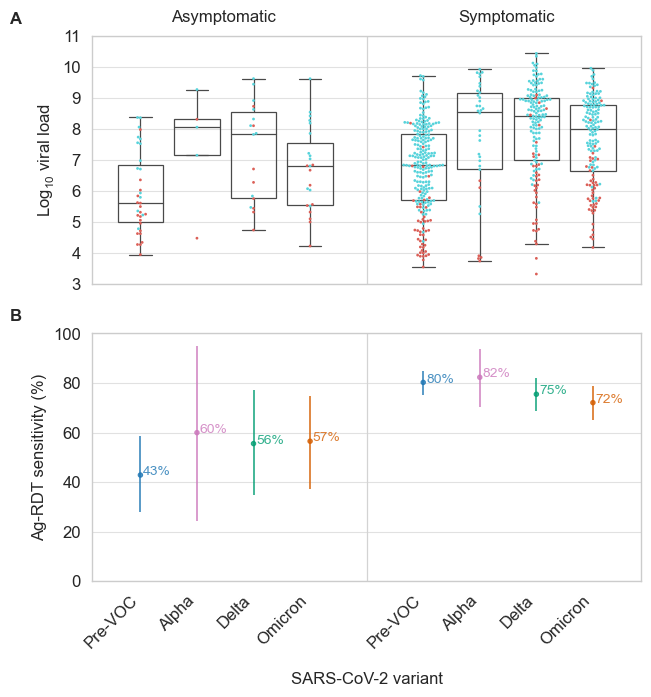

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(colWidth*2, colWidth*2))
ax1, ax2 = ax

plotFigA2_A(dfFigureA2, variantSympDict, label, palette=pal, order=order, ax=ax1, fontSizePlot=fontSizePlot)
_, _ = plotFigA2_B(dfFigureA2, statsDictFigure3, variantSympDict, variantSympPalette=variantSympPal,
                   label=label, ax=ax2, fontSizePlot=fontSizePlot)

fig.text(0.31, 0.9, "Asymptomatic", ha="center", fontdict={"fontsize": fontSizePlot})
fig.text(0.71, 0.9, "Symptomatic", ha="center", fontdict={"fontsize": fontSizePlot})

annotateWithLetters(ax, size=fontSizePlot, coords=(-0.15, 1.05))

plt.savefig(f"{plotDir}/FigureA2.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA2.pdf", dpi=600, bbox_inches="tight")

In [33]:
statsDictPrint = defaultdict(lambda: defaultdict(dict))
for variant in order.variant[1:]:
    diffAsymp = statsDictFigure3["variant:symptoms"][f"wildtype, 0"]["samples"] - statsDictFigure3["variant:symptoms"][f"{variant}, 0"]["samples"]
    diffSymp = statsDictFigure3["variant:symptoms"][f"wildtype, 1"]["samples"] - statsDictFigure3["variant:symptoms"][f"{variant}, 1"]["samples"]

    statsDictPrint[variant]["asymp"]["mean"] = np.mean(diffAsymp)
    statsDictPrint[variant]["asymp"]["hdi"] = az.hdi(diffAsymp, 0.94)
    statsDictPrint[variant]["symp"]["mean"] =  np.mean(diffSymp)
    statsDictPrint[variant]["symp"]["hdi"] =  az.hdi(diffSymp, 0.94)

In [34]:
print("Estimated differences in Ag-RDT sensitivity compared to sensitivity in Pre-VOC cases:\n")
for variant, stats in statsDictPrint.items():
    print(variantAbbrvs[variant])
    for sympStatus, statistic in stats.items():
        print("Asymptomatic" if sympStatus == "asymp" else "Symptomatic")
        print(f"Mean: {statistic['mean']:.4f}")
        print(f"94% Hdi: {statistic['hdi'][0]:.4f}, {statistic['hdi'][1]:.4f}")
        print()
    print()

Estimated differences in Ag-RDT sensitivity compared to sensitivity in Pre-VOC cases:

Alpha
Asymptomatic
Mean: -0.1711
94% Hdi: -0.5509, 0.2329

Symptomatic
Mean: -0.0207
94% Hdi: -0.1490, 0.1082


Delta
Asymptomatic
Mean: -0.1268
94% Hdi: -0.3836, 0.1435

Symptomatic
Mean: 0.0477
94% Hdi: -0.0342, 0.1301


Omicron
Asymptomatic
Mean: -0.1365
94% Hdi: -0.3750, 0.1136

Symptomatic
Mean: 0.0818
94% Hdi: -0.0023, 0.1650




In [225]:
print(f"Counts (asymptomatic people): {', '.join(countsFigureA2_Asymp)}")
print(f"Counts (symptomatic people): {', '.join(countsFigureA2_Symp)}")

Counts (asymptomatic people): n=35, n=5, n=18, n=23
Counts (symptomatic people): n=238, n=34, n=153, n=157


In [226]:
print(f"Counts (asymptomatic people) Agrdt negative/positive")
for countStr in countsFigureA2Verbose_Asymp:
    variant, agrdt, count = split(",|:", countStr.replace(" ", "").replace("(", "").replace(")", ""))
    agrdtStr = "positive" if int(agrdt) else "negative"   
    print(f"{variant}, {agrdtStr}: {count}")
print()
print(f"Counts (symptomatic people) Agrdt negative/positive")
for countStr in countsFigureA2Verbose_Symp:
    variant, agrdt, count = split(",|:", countStr.replace(" ", "").replace("(", "").replace(")", ""))
    agrdtStr = "positive" if int(agrdt) else "negative"   
    print(f"{variant}, {agrdtStr}: {count}")

Counts (asymptomatic people) Agrdt negative/positive
wildtype, negative: 20
wildtype, positive: 15
alpha, negative: 2
alpha, positive: 3
delta, negative: 8
delta, positive: 10
omicron, negative: 10
omicron, positive: 13

Counts (symptomatic people) Agrdt negative/positive
wildtype, negative: 47
wildtype, positive: 191
alpha, negative: 6
alpha, positive: 28
delta, negative: 37
delta, positive: 116
omicron, negative: 45
omicron, positive: 112


# Regression

## Differences between subgroups

### Viral load differences between different time periods (Figure 1)

In [73]:
priors = {"1|samplingMonth2": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2))}
modelVl, iDataVl, statsVl = sampleVl(df=dfFigure1_B, catVars=["samplingMonth2"], likelihood="skewnormal",
                                     formula="zVl ~ (1|samplingMonth2)", priors=priors, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|samplingMonth2_sigma, 1|samplingMonth2_offset, zVl_sigma, zVl_alpha]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 249 seconds.


In [74]:
print("Difference in log10 viral loads between start of study (Dec 20/Jan 21) and remaining time periods.\n")
vlStd = statsVl["sd"]
baseline = iDataVl.posterior.sel({"samplingMonth2__factor_dim": "0"})["1|samplingMonth2"].stack(samples=("chain", "draw")).values.flatten() 
for samplingTime, samplingTimeStr in month2ToMonths.items():
    if samplingTime == 3: continue # No data for June/July
    print(samplingTimeStr)
    samples = iDataVl.posterior.sel({"samplingMonth2__factor_dim": f"{int(samplingTime)}"})["1|samplingMonth2"].stack(samples=("chain", "draw")).values.flatten() 
    # Convert back to original scale
    samplesDiff = (samples - baseline) * vlStd
    samplingTimeDiffMean = samplesDiff.mean()
    samplingTimeDiffHDI = az.hdi(samplesDiff , 0.94)

    print(f"{samplingTimeStr}: {samplingTimeDiffMean:.2f}")
    print(f"94% HDI: {samplingTimeDiffHDI[0]:.2f}, {samplingTimeDiffHDI[1]:.2f}")
    print()
    print()

Difference in log10 viral loads between start of study (Dec 20/Jan 21) and remaining time periods.

Dec '20 - Jan '21
Dec '20 - Jan '21: 0.00
94% HDI: 0.00, 0.00


Feb '21 - March '21
Feb '21 - March '21: -0.14
94% HDI: -0.45, 0.17


April '21 - May '21
April '21 - May '21: 1.15
94% HDI: 0.76, 1.55


Aug '21 - Sep '21
Aug '21 - Sep '21: 1.29
94% HDI: 0.80, 1.77


Oct '21 - Nov '21
Oct '21 - Nov '21: 1.03
94% HDI: 0.78, 1.29


Dec '21 - Jan '22
Dec '21 - Jan '22: 0.92
94% HDI: 0.70, 1.13


Feb '22
Feb '22: 0.68
94% HDI: 0.34, 1.00




In [337]:
iDataVl.to_netcdf(iDataDir + "fig1BVl.nc")

'../output/iData/fig1BVl.nc'

### Difference in viral loads between non-AgRDT tested samples and Ag-RDT tested samples (Figure 2B)

In [35]:
variantModels = {}
variantIData = {}
variantDfs = {}
dfTtestVariant = dfFigure2_B.copy()

In [36]:
for variant in order.variant:
    means = dfTtestVariant[dfTtestVariant.variant==variant].groupby("agrdtYN").vl.mean()
    print(f"Mean log10 viral load for {abbrvDictPaper['variant'][variant]} samples.\n"
          f"No Ag-RDT performed: {means[False]:.2f}, Ag-RDT performed: {means[True]:.2f}\n")

Mean log10 viral load for Pre-VOC samples.
No Ag-RDT performed: 6.72, Ag-RDT performed: 6.76

Mean log10 viral load for Alpha samples.
No Ag-RDT performed: 9.02, Ag-RDT performed: 7.70

Mean log10 viral load for Delta samples.
No Ag-RDT performed: 8.22, Ag-RDT performed: 7.99

Mean log10 viral load for Omicron samples.
No Ag-RDT performed: 7.99, Ag-RDT performed: 7.64



In [37]:
priors = {"variant": bmb.Prior("Normal", mu=0, sigma=2),
          "agrdtYN:variant": bmb.Prior("Normal", mu=0, sigma=2)}
modelAgrdtYNVl, iDataAgrdtYNVl, statsAgrdtYNVl = sampleVl(dfTtestVariant, catVars=["agrdtYN", "variant"], likelihood="skewnormal",
                                                          target_accept=0.95, priors=priors, seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, variant, agrdtYN:variant, zVl_sigma, zVl_alpha]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 505 seconds.


In [46]:
iDataAgrdtYNVl.to_netcdf(Path(iDataDir, "fig2BVl.nc"))

PosixPath('../paper/20240316-resubmission-2/iData/fig2BVl.nc')

In [47]:
az.summary(iDataAgrdtYNVl)

mean   sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        1.78 0.35    1.17     2.47       0.00   
variant[delta]                  -0.32 0.36   -1.02     0.33       0.00   
variant[omicron]                -0.39 0.35   -1.09     0.23       0.00   
variant[wildtype]               -1.11 0.36   -1.78    -0.44       0.00   
agrdtYN:variant[True, alpha]    -0.36 0.37   -1.07     0.32       0.00   
agrdtYN:variant[True, delta]    -0.04 0.11   -0.25     0.17       0.00   
agrdtYN:variant[True, omicron]  -0.19 0.07   -0.32    -0.06       0.00   
agrdtYN:variant[True, wildtype]  0.00 0.08   -0.15     0.16       0.00   
zVl_alpha                       -4.28 0.44   -5.09    -3.47       0.00   
zVl_sigma                        1.49 0.04    1.41     1.56       0.00   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                           0.00  13244.00  13151.00   1.00  
variant[delta]                      0.00  13291.00  13623.00   1.00  
variant[omicron]                    0.00  13263.00  13402.00   1.00  
variant[wildtype]                   0.00  13152.00  13459.00   1.00  
agrdtYN:variant[True, alpha]        0.00  13850.00  13848.00   1.00  
agrdtYN:variant[True, delta]        0.00  31873.00  24776.00   1.00  
agrdtYN:variant[True, omicron]      0.00  34632.00  26829.00   1.00  
agrdtYN:variant[True, wildtype]     0.00  37956.00  27894.00   1.00  
zVl_alpha                           0.00  23582.00  24564.00   1.00  
zVl_sigma                           0.00  25340.00  28161.00   1.00

In [48]:
print("Difference in log10 viral loads when comparing people who were not Ag-RDT tested vs who were.\n")
vlStd = statsAgrdtYNVl["sd"]
for variant in order.variant:
    samples = iDataAgrdtYNVl.posterior.sel({"agrdtYN:variant_dim": f"True, {variant}"})["agrdtYN:variant"].stack(samples=("chain", "draw", )).values.flatten()  
    # Convert back to original scale
    samples = samples * vlStd
    agrdtYNParamMean = samples.mean()
    agrdtYNParamHDI = az.hdi(samples, 0.94)
    
    print(f"{abbrvDictPaper['variant'][variant]}: {agrdtYNParamMean:.3f}")
    print(f"94% HDI: {agrdtYNParamHDI[0]:.3f}, {agrdtYNParamHDI[1]:.3f}")
    print()

Difference in log10 viral loads when comparing people who were not Ag-RDT tested vs who were.

Pre-VOC: 0.001
94% HDI: -0.233, 0.246

Alpha: -0.544
94% HDI: -1.611, 0.476

Delta: -0.056
94% HDI: -0.378, 0.252

Omicron: -0.283
94% HDI: -0.477, -0.087



### Viral load difference between immunized and immune-naive people (Figure 3)

In [75]:
priors = {"symptoms": bmb.Prior("Normal", mu=0, sigma=2),
          "immun2YN:symptoms": bmb.Prior("Normal", mu=0, sigma=2)}
modelImmunVlSkewed, iDataImmunVlSkewed, statsImmunVlSkewed = sampleVl(df=dfFigure3, catVars=["immun2YN", "symptoms"], 
                                                                      likelihood="skewnormal", priors=priors, target_accept=0.95, 
                                                                      seed=SEED, interaction=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, symptoms, immun2YN:symptoms, zVl_sigma, zVl_alpha]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 124 seconds.


In [76]:
modelImmunVlSkewed

Formula: zVl ~ immun2YN:symptoms
Family name: Skewnormal
Link: identity
Observations: 722
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 2.5)
    symptoms ~ Normal(mu: 0, sigma: 2)
    immun2YN:symptoms ~ Normal(mu: 0, sigma: 2)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1)
    alpha ~ Normal(mu: 0, sigma: 5)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [338]:
iDataImmunVlSkewed.to_netcdf(iDataDir + "fig3AVl.nc")

'../output/iData/fig3AVl.nc'

In [77]:
az.summary(iDataImmunVlSkewed)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                0.71 0.14    0.44     0.98       0.00     0.00   
symptoms[1]              0.26 0.14    0.00     0.51       0.00     0.00   
immun2YN:symptoms[1, 0]  0.19 0.18   -0.15     0.51       0.00     0.00   
immun2YN:symptoms[1, 1]  0.49 0.07    0.36     0.62       0.00     0.00   
zVl_alpha               -3.36 0.54   -4.39    -2.38       0.00     0.00   
zVl_sigma                1.51 0.06    1.39     1.63       0.00     0.00   

                         ess_bulk  ess_tail  r_hat  
Intercept                20469.00  23715.00   1.00  
symptoms[1]              23031.00  26531.00   1.00  
immun2YN:symptoms[1, 0]  23642.00  26591.00   1.00  
immun2YN:symptoms[1, 1]  23248.00  24066.00   1.00  
zVl_alpha                15980.00  20704.00   1.00  
zVl_sigma                16993.00  21717.00   1.00

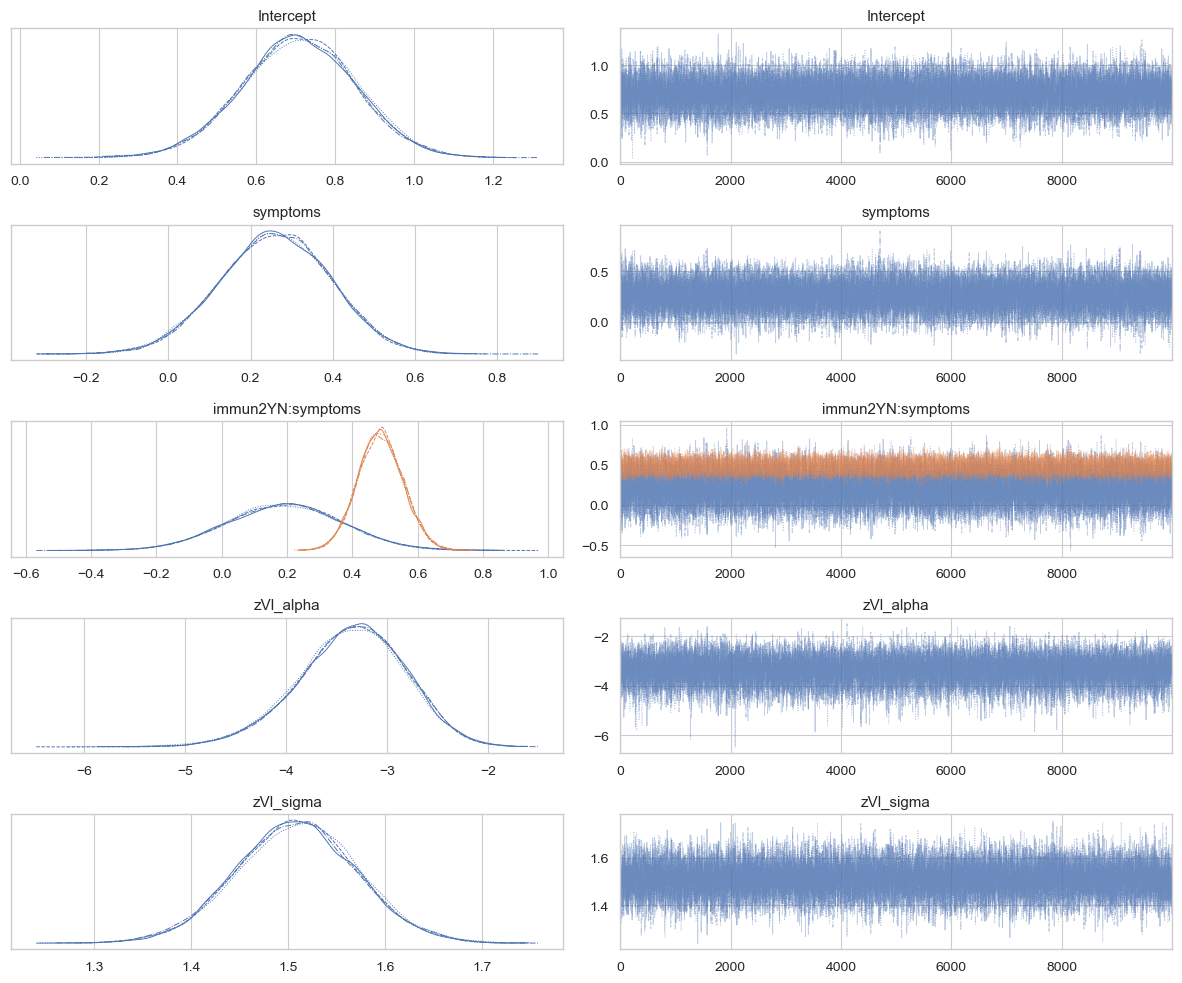

In [78]:
az.plot_trace(iDataImmunVlSkewed)
plt.tight_layout()

#### Posterior analysis

##### Looking at mean viral load

In [79]:
print("Mean log10 viral loads according to immunization status, depending on whether people had symptoms.\n")
vlStd = statsImmunVlSkewed["sd"]
vlMean = statsImmunVlSkewed["mean"]

# Compute the mean of a skewed normal distribution.
# Formula: mean + sigma * sqrt(2/pi) * alpha/sqrt(1 + alpha^2)
zVl_sigma = iDataImmunVlSkewed.posterior["zVl_sigma"].stack(samples=("chain", "draw")).values.flatten() 
zVl_alpha = iDataImmunVlSkewed.posterior["zVl_alpha"].stack(samples=("chain", "draw")).values.flatten() 
commonTermMean = zVl_sigma * np.sqrt(2/np.pi) * (zVl_alpha/np.sqrt(1 + np.power(zVl_alpha, 2)))

intercept = iDataImmunVlSkewed.posterior["Intercept"].stack(samples=("chain", "draw")).values.flatten()
betaSymptoms = iDataImmunVlSkewed.posterior["symptoms"].stack(samples=("chain", "draw")).values.flatten()


for symptomStatus in order.symp:
    for immunized in 0, 1:
        print(f"{abbrvDictPaper['symptoms'][symptomStatus]}, immunized: {abbrvDictPaper['immun2YN'][immunized]}")
        if immunized:
            samples = iDataImmunVlSkewed.posterior.sel({"immun2YN:symptoms_dim": f"1, {symptomStatus}"})["immun2YN:symptoms"].stack(samples=("chain", "draw")).values  
        else:
            samples = 0
        # Convert back to original scale
        samples = (intercept + betaSymptoms * symptomStatus + samples + commonTermMean) * vlStd + vlMean
        immun2YNParamMean = samples.mean()
        immun2YNParamHDI = az.hdi(samples , 0.94)

        print(f"{abbrvDictPaper['immun2YN'][symptomStatus]}: {immun2YNParamMean:.3f}")
        print(f"94% HDI: {immun2YNParamHDI[0]:.3f}, {immun2YNParamHDI[1]:.3f}")
        print()

Mean log10 viral loads according to immunization status, depending on whether people had symptoms.

asymptomatic, immunized: no
no: 6.606
94% HDI: 6.253, 6.984

asymptomatic, immunized: yes
no: 6.899
94% HDI: 6.546, 7.256

symptomatic, immunized: no
yes: 6.998
94% HDI: 6.846, 7.149

symptomatic, immunized: yes
yes: 7.736
94% HDI: 7.590, 7.874



##### Looking at vl differences according to immunization status

In [420]:
print("Difference in log10 viral loads, depending on whether people had symptoms.\n")
vlStd = statsImmunVlSkewed["sd"]
for symptomStatus in (0, 1):
    samples = iDataImmunVlSkewed.posterior.sel({"immun2YN:symptoms_dim": f"1, {symptomStatus}"})["immun2YN:symptoms"].stack(samples=("chain", "draw")).values  
    # Convert back to original scale
    samples = samples * vlStd
    immun2YNParamMean = samples.mean()
    immun2YNParamHDI = az.hdi(samples , 0.94)
    
    sympString = "Symptomatic" if symptomStatus else "Asymptomatic"
    print(f"{sympString}: {immun2YNParamMean:.3f}")
    print(f"94% HDI: {immun2YNParamHDI[0]:.3f}, {immun2YNParamHDI[1]:.3f}")
    print()

Difference in log10 viral loads, depending on whether people had symptoms.

Asymptomatic: 0.293
94% HDI: -0.229, 0.777

Symptomatic: 0.737
94% HDI: 0.541, 0.937



##### Posterior predictions

In [81]:
ppcSkewed = pm.sample_posterior_predictive(iDataImmunVlSkewed, model=modelImmunVlSkewed.backend.model, 
                                           var_names=["zVl"], random_seed=SEED)

Sampling: [zVl]


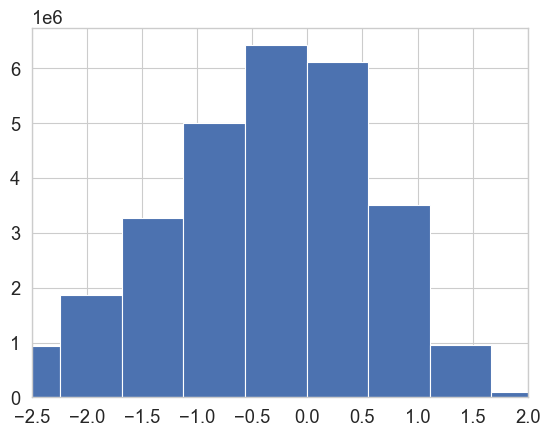

In [82]:
_, ax = plt.subplots(1, 1)
ax.set_xlim(-2.5, 2)
ax.hist(ppcSkewed.posterior_predictive.zVl.values.flatten(), bins=20);

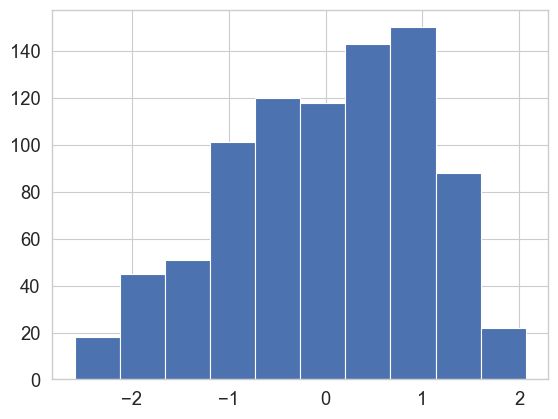

In [83]:
dfCurr = dfFigure3.copy()
standardize(dfCurr, "vl", "zVl")
plt.hist(dfCurr.zVl);

### Viral load differences between SARS-CoV-2 variants (Figure A2)

In [49]:
dfVariantVl = dfFigureA2.dropna(subset=["variant"]).copy()
priors = {"symptoms": bmb.Prior("Normal", mu=0, sigma=2),
          "variantCode:symptoms": bmb.Prior("Normal", mu=0, sigma=2)}
dfVariantVl["variantCode"] = pd.Categorical(dfVariantVl.variant, categories=order.variant).codes
modelVariantVlSkewed, iDataVariantVlSkewed, statsVariantVlSkewed = sampleVl(df=dfVariantVl, catVars=["variantCode", "symptoms"], likelihood="skewnormal",
                                                                            target_accept=0.95, priors=priors, seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, symptoms, variantCode:symptoms, zVl_sigma, zVl_alpha]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 140 seconds.


In [50]:
modelVariantVlSkewed

Formula: zVl ~ variantCode:symptoms
Family name: Skewnormal
Link: identity
Observations: 658
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 2.5)
    symptoms ~ Normal(mu: 0, sigma: 2)
    variantCode:symptoms ~ Normal(mu: 0, sigma: 2)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1)
    alpha ~ Normal(mu: 0, sigma: 5)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [52]:
iDataVariantVlSkewed.to_netcdf(Path(iDataDir, "figA2AVl.nc"))

PosixPath('../paper/20240316-resubmission-2/iData/figA2AVl.nc')

In [53]:
az.summary(iDataVariantVlSkewed)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                   0.38 0.15    0.10     0.66       0.00     0.00   
symptoms[1]                 0.45 0.14    0.17     0.71       0.00     0.00   
variantCode:symptoms[1, 0]  0.93 0.37    0.25     1.62       0.00     0.00   
variantCode:symptoms[1, 1]  0.73 0.14    0.48     0.99       0.00     0.00   
variantCode:symptoms[2, 0]  0.87 0.23    0.46     1.30       0.00     0.00   
variantCode:symptoms[2, 1]  0.74 0.08    0.59     0.89       0.00     0.00   
variantCode:symptoms[3, 0]  0.46 0.21    0.06     0.87       0.00     0.00   
variantCode:symptoms[3, 1]  0.53 0.08    0.38     0.68       0.00     0.00   
zVl_alpha                  -3.93 0.58   -4.97    -2.80       0.00     0.00   
zVl_sigma                   1.48 0.06    1.37     1.59       0.00     0.00   

                            ess_bulk  ess_tail  r_hat  
Intercept                   23654.00  26220.00   1.00  
symptoms[1]                 25982.00  25714.00   1.00  
variantCode:symptoms[1, 0]  32260.00  25174.00   1.00  
variantCode:symptoms[1, 1]  38217.00  28576.00   1.00  
variantCode:symptoms[2, 0]  30893.00  29916.00   1.00  
variantCode:symptoms[2, 1]  34451.00  30113.00   1.00  
variantCode:symptoms[3, 0]  28439.00  27671.00   1.00  
variantCode:symptoms[3, 1]  34371.00  30962.00   1.00  
zVl_alpha                   22574.00  25600.00   1.00  
zVl_sigma                   24606.00  27405.00   1.00

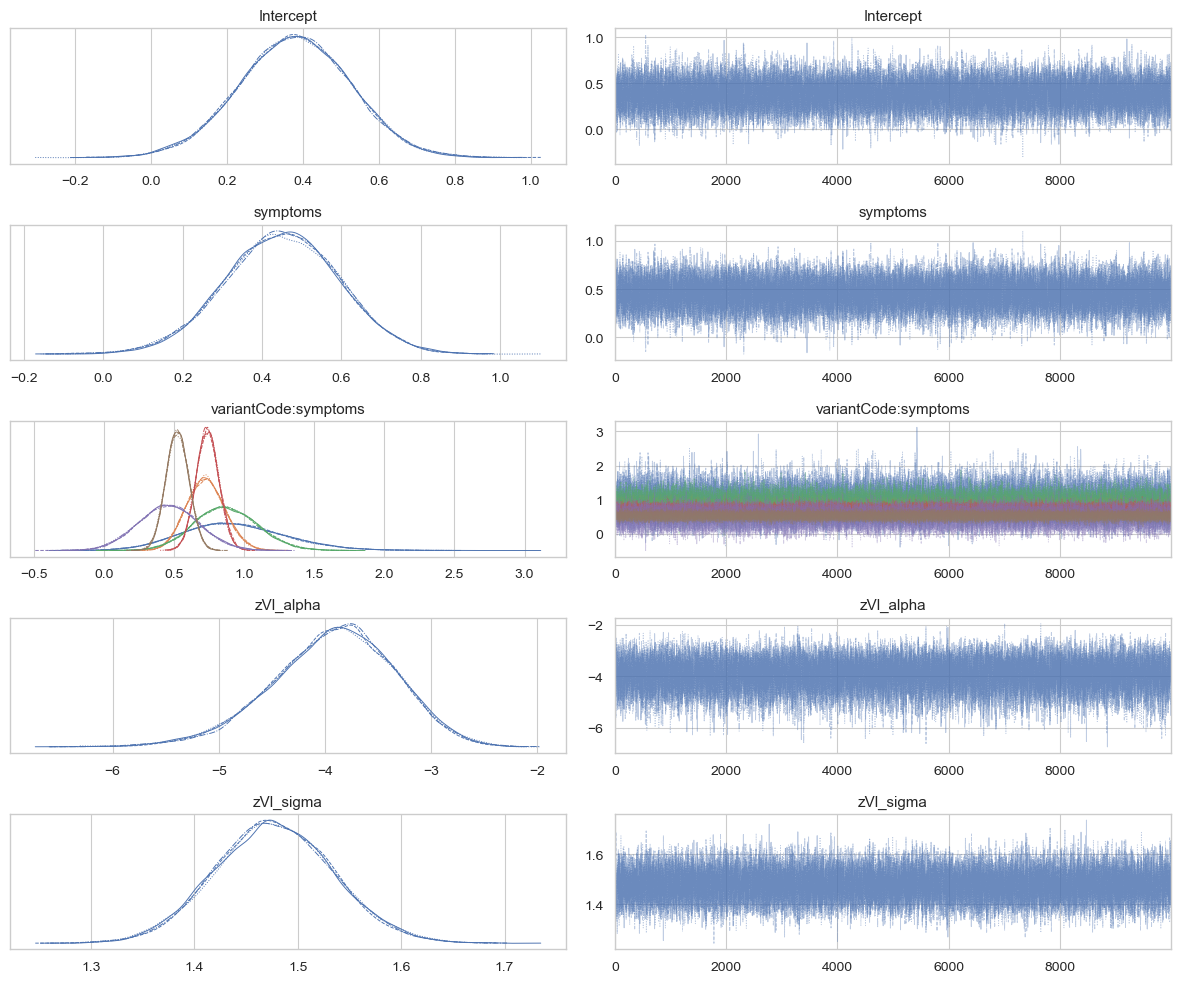

In [54]:
az.plot_trace(iDataVariantVlSkewed)
plt.tight_layout()

#### Posterior analysis

##### Mean viral loads

In [56]:
print("Mean log10 viral loads according to virus variant (with wildtype being the baseline), depending on whether people had symptoms.\n")
vlStd = statsVariantVlSkewed["sd"]
vlMean = statsVariantVlSkewed["mean"]

# Compute the mean of a skewed normal distribution.
# Formula: mean + sigma * sqrt(2/pi) * alpha/sqrt(1 + alpha^2)
zVl_sigma = iDataVariantVlSkewed.posterior["zVl_sigma"].stack(samples=("chain", "draw")).values.flatten() 
zVl_alpha = iDataVariantVlSkewed.posterior["zVl_alpha"].stack(samples=("chain", "draw")).values.flatten() 
commonTermMean = zVl_sigma * np.sqrt(2/np.pi) * (zVl_alpha/np.sqrt(1 + np.power(zVl_alpha, 2)))

intercept = iDataVariantVlSkewed.posterior["Intercept"].stack(samples=("chain", "draw")).values.flatten()

betaSymptoms = iDataVariantVlSkewed.posterior["symptoms"].stack(samples=("chain", "draw")).values.flatten()

for variantCode, variantStr in zip(range(4), order.variant):
    for symptomStatus in order.symp:
        print(abbrvDictPaper["symptoms"][symptomStatus])
        if variantCode:
            samples = iDataVariantVlSkewed.posterior.sel({"variantCode:symptoms_dim": f"{variantCode}, {symptomStatus}"})["variantCode:symptoms"].stack(samples=("chain", "draw")).values.flatten() 
        else:
            samples = 0
        # Convert back to original scale
        samples = (intercept + betaSymptoms * symptomStatus + samples + commonTermMean) * vlStd + vlMean
        variantParamMean = samples.mean()
        variantParamHDI = az.hdi(samples , 0.94)

        print(f"{abbrvDictPaper['variant'][variantStr]}: {variantParamMean:.2f}")
        print(f"94% HDI: {variantParamHDI[0]:.2f}, {variantParamHDI[1]:.2f}")
        print()
    print()

Mean log10 viral loads according to virus variant (with wildtype being the baseline), depending on whether people had symptoms.

asymptomatic
Pre-VOC: 6.09
94% HDI: 5.70, 6.50

symptomatic
Pre-VOC: 6.79
94% HDI: 6.62, 6.95


asymptomatic
Alpha: 7.54
94% HDI: 6.57, 8.55

symptomatic
Alpha: 7.93
94% HDI: 7.56, 8.30


asymptomatic
Delta: 7.45
94% HDI: 6.93, 7.97

symptomatic
Delta: 7.95
94% HDI: 7.76, 8.14


asymptomatic
Omicron: 6.81
94% HDI: 6.33, 7.33

symptomatic
Omicron: 7.61
94% HDI: 7.43, 7.80




##### Viral load differences between variants

In [58]:
print("Difference in log10 viral loads (with wildtype being the baseline), depending on whether people had symptoms.\n")
vlStd = statsVariantVlSkewed["sd"]
for variantCode, variantStr in zip(range(1, 4), order.variant[1:]):
    for symptomStatus in order.symp:
        print(abbrvDictPaper["symptoms"][symptomStatus])
        samples = iDataVariantVlSkewed.posterior.sel({"variantCode:symptoms_dim": f"{variantCode}, {symptomStatus}"})["variantCode:symptoms"].stack(samples=("chain", "draw")).values.flatten() 
        # Convert back to original scale
        samples = samples * vlStd
        variantParamMean = samples.mean()
        variantParamHDI = az.hdi(samples , 0.94)

        print(f"{abbrvDictPaper['variant'][variantStr]}: {variantParamMean:.2f}")
        print(f"94% HDI: {variantParamHDI[0]:.2f}, {variantParamHDI[1]:.2f}")
        print()
    print()

Difference in log10 viral loads (with wildtype being the baseline), depending on whether people had symptoms.

asymptomatic
Alpha: 1.45
94% HDI: 0.40, 2.53

symptomatic
Alpha: 1.13
94% HDI: 0.75, 1.54


asymptomatic
Delta: 1.36
94% HDI: 0.72, 2.03

symptomatic
Delta: 1.15
94% HDI: 0.91, 1.39


asymptomatic
Omicron: 0.72
94% HDI: 0.10, 1.36

symptomatic
Omicron: 0.82
94% HDI: 0.59, 1.06




##### Posterior predictions

In [59]:
ppcSkewed = pm.sample_posterior_predictive(iDataVariantVlSkewed, model=modelVariantVlSkewed.backend.model, var_names=["zVl"], random_seed=SEED)

Sampling: [zVl]


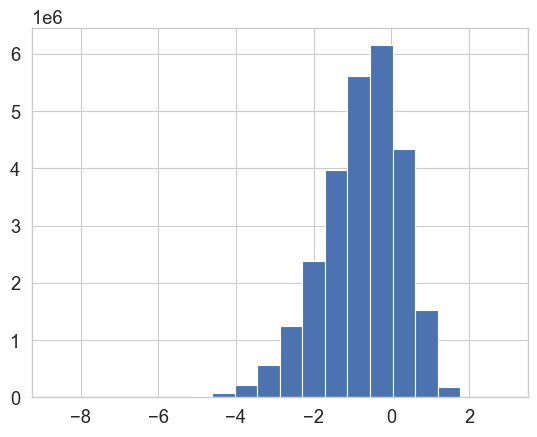

In [60]:
_, ax = plt.subplots(1, 1)
#ax.set_xlim(-2.5, 2)
ax.hist(ppcSkewed.posterior_predictive.zVl.values.flatten(), bins=20);

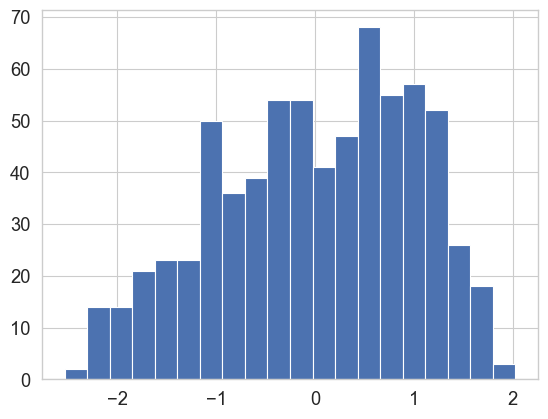

In [97]:
dfCurr = dfVariantVl.copy()
standardize(dfCurr, "vl", "zVl")
plt.hist(dfCurr.zVl, bins=20);

### Days post symptom onset difference between SARS-CoV-2 variants (Figure 2A)

In [38]:
dfDaysOnset = dfFigure2_A.copy()
dfDaysOnset["variant"] = pd.Categorical(dfDaysOnset["variant"], categories=["wildtype", "alpha", "delta", "omicron"]).codes

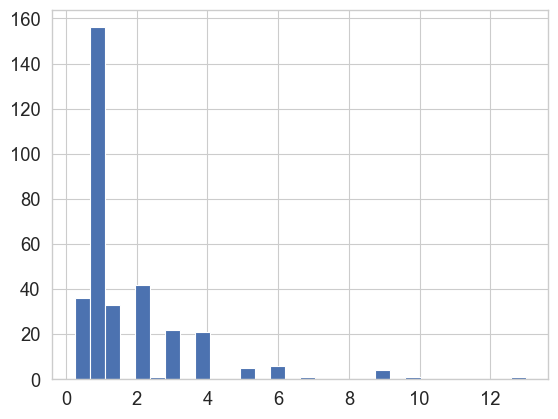

In [39]:
plt.hist(dfDaysOnset.daysPostOnset, bins=30);

In [63]:
modelDaysOnset = bmb.Model(data=dfDaysOnset, formula="daysPostOnset ~ variant", categorical=["variant"],
                           dropna=True, family="gamma")
modelDaysOnset.build()
modelDaysOnset

Formula: daysPostOnset ~ variant
Family name: Gamma
Link: inverse
Observations: 329
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.267)
    variant ~ Normal(mu: [0. 0. 0.], sigma: [11.2936  5.7794  5.8276])

  Auxiliary parameters
    alpha ~ HalfCauchy(beta: 1)

In [64]:
iDataDaysOnset = modelDaysOnset.fit(tune=4000, draws=10000, target_accept=0.9, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, variant, daysPostOnset_alpha]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 39 seconds.


In [65]:
iDataDaysOnset.to_netcdf(Path(iDataDir, "fig2ADays.nc"))

PosixPath('../paper/20240316-resubmission-2/iData/fig2ADays.nc')

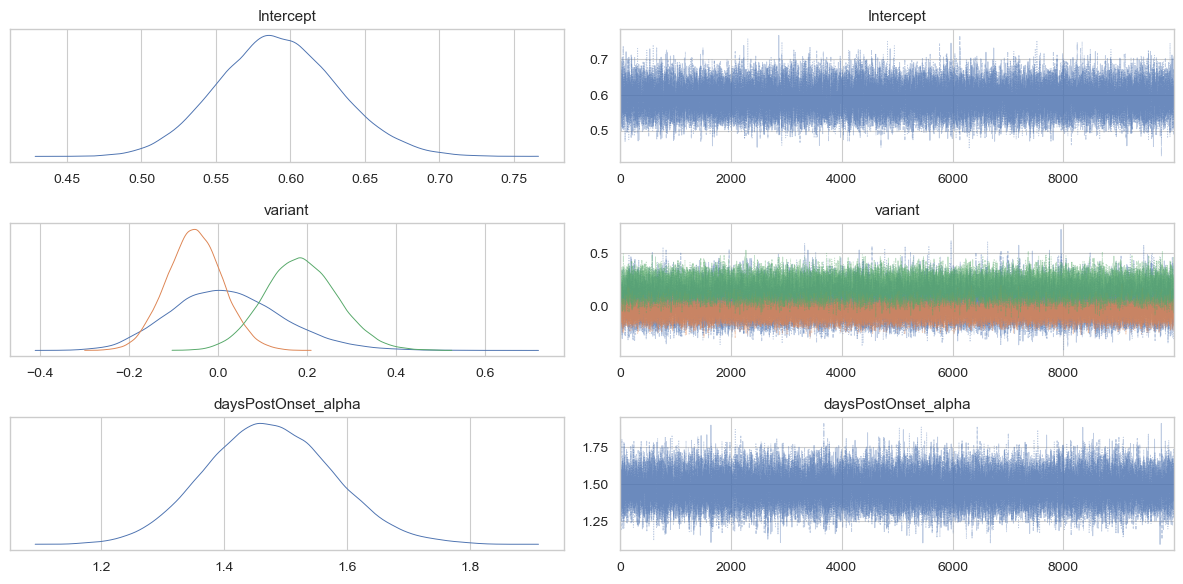

In [66]:
az.plot_trace(iDataDaysOnset, combined=True);
plt.tight_layout()

In [67]:
az.summary(iDataDaysOnset)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept            0.59 0.04    0.52     0.67       0.00     0.00  43352.00   
variant[1]           0.02 0.13   -0.21     0.26       0.00     0.00  42035.00   
variant[2]          -0.05 0.06   -0.17     0.07       0.00     0.00  42534.00   
variant[3]           0.19 0.08    0.04     0.35       0.00     0.00  40330.00   
daysPostOnset_alpha  1.47 0.10    1.28     1.67       0.00     0.00  42854.00   

                     ess_tail  r_hat  
Intercept            27517.00   1.00  
variant[1]           27926.00   1.00  
variant[2]           31254.00   1.00  
variant[3]           31656.00   1.00  
daysPostOnset_alpha  29188.00   1.00

## Comprehensive models (Figs 4 + A3)

### Include variable for SARS-CoV-2 variant

In [104]:
indVars, zIndVars, indCatVars = logisticRegressionVars()

In [105]:
formulaAllInd = f"agrdt ~ testDevice +  variant + gender + binDaysPostOnset + (0 + binDaysPostOnset|variant) + zVl + (0 + zVl|variant) + zAge"
dfLogisticBmb1 = logisticRegressionDf(dfPos)
priors = {"zVl": bmb.Prior("Lognormal", mu=1, sigma=1),
          "zVl|variant": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
          "binDaysPostOnset|variant": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
          "testDevice": bmb.Prior("Normal", mu=-0.5, sigma=0.57),
          "zAge": bmb.Prior("Normal", mu=0, sigma=1),
          "gender": bmb.Prior("Normal", mu=0, sigma=1)}
bmbModel1 = bmb.Model(formulaAllInd, dfLogisticBmb1, priors=priors, family="bernoulli", categorical=list(indCatVars), noncentered=True) #, dropna=True)
bmbModel1.build()

In [106]:
bmbModel1

Formula: agrdt ~ testDevice +  variant + gender + binDaysPostOnset + (0 + binDaysPostOnset|variant) + zVl + (0 + zVl|variant) + zAge
Family name: Bernoulli
Link: logit
Observations: 417
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.5602)
    testDevice ~ Normal(mu: -0.5, sigma: 0.57)
    variant ~ Normal(mu: [0. 0. 0.], sigma: [9.6752 6.2899 5.364 ])
    gender ~ Normal(mu: 0, sigma: 1)
    binDaysPostOnset ~ Normal(mu: 0.0, sigma: 6.3492)
    zVl ~ Lognormal(mu: 1, sigma: 1)
    zAge ~ Normal(mu: 0, sigma: 1)

  Group-level effects
    binDaysPostOnset|variant ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))
    zVl|variant ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))

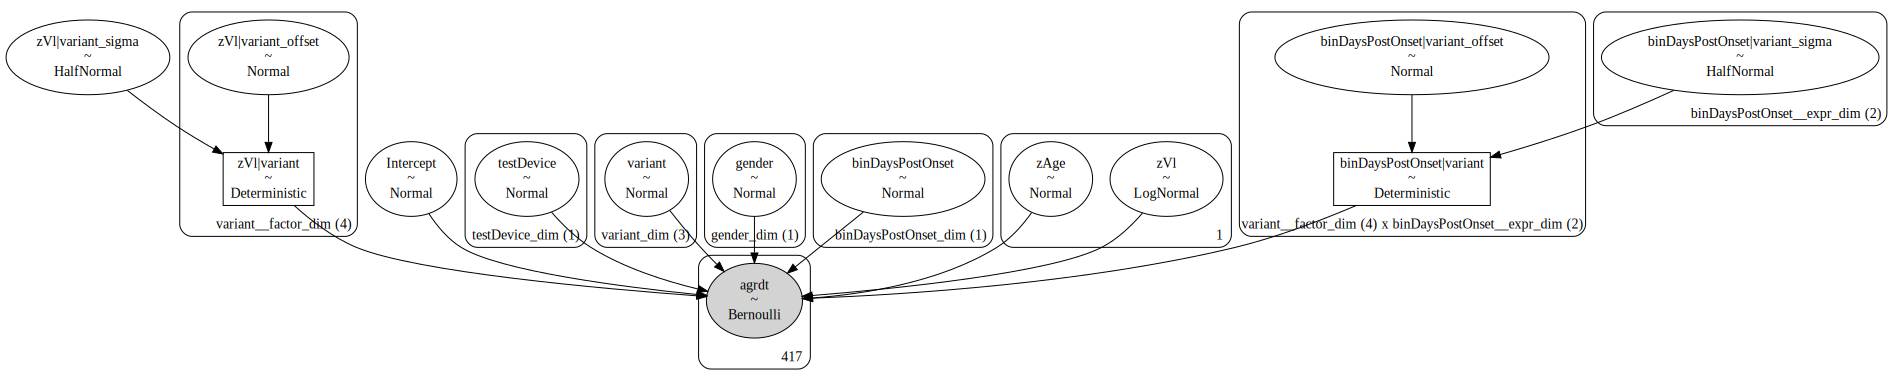

In [107]:
bmbModel1.graph()

In [23]:
iDataFigA3B = Path(iDataDir, "figA3B.nc")
if iDataFigA3B.exists():
    iDataBmb1 = az.from_netcdf(iDataFigA3B)
else:
    iDataBmb1 = bmbModel1.fit(target_accept=0.99, draws=10000, tune=4000, random_seed=SEED)#draws=10000, tune=4000)

In [341]:
iDataBmb1.to_netcdf(iDataFigA3B)

'../output/iData/figA3B.nc'

#### Posterior analysis

##### Process binDaysPostOnset|variant

In [24]:
daysPostOnset = iDataBmb1.posterior.sel(binDaysPostOnset_dim="1")["binDaysPostOnset"]

In [25]:
wt_days1 = iDataBmb1.posterior.sel(variant__factor_dim="0", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|variant"]
wt_days2 = iDataBmb1.posterior.sel(variant__factor_dim="0", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|variant"]
wt_diff = wt_days2 - wt_days1 + daysPostOnset

alpha_days1 = iDataBmb1.posterior.sel(variant__factor_dim="1", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|variant"]
alpha_days2 = iDataBmb1.posterior.sel(variant__factor_dim="1", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|variant"]
alpha_diff = alpha_days2 - alpha_days1 + daysPostOnset

delta_days1 = iDataBmb1.posterior.sel(variant__factor_dim="2", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|variant"]
delta_days2 = iDataBmb1.posterior.sel(variant__factor_dim="2", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|variant"]
delta_diff = delta_days2 - delta_days1 + daysPostOnset

omicron_days1 = iDataBmb1.posterior.sel(variant__factor_dim="3", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|variant"]
omicron_days2 = iDataBmb1.posterior.sel(variant__factor_dim="3", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|variant"]
omicron_diff = omicron_days2 - omicron_days1 + daysPostOnset

In [26]:
days_variant = xarray.concat([wt_diff, alpha_diff, delta_diff, omicron_diff], dim="daysVariant_dim")
days_variant.name="daysVariant"

In [27]:
iDataBmb1.posterior["daysVariant"] = days_variant

##### Process zVl|variant

In [28]:
zVl = iDataBmb1.posterior["zVl"]

In [29]:
wt_zVl = iDataBmb1.posterior.sel(variant__factor_dim="0")["zVl|variant"] + zVl
alpha_zVl = iDataBmb1.posterior.sel(variant__factor_dim="1")["zVl|variant"] + zVl
delta_zVl = iDataBmb1.posterior.sel(variant__factor_dim="2")["zVl|variant"] + zVl
omicron_zVl = iDataBmb1.posterior.sel(variant__factor_dim="3")["zVl|variant"] + zVl

In [30]:
alpha_wt_zVl = (alpha_zVl - wt_zVl)
delta_wt_zVl = (delta_zVl - wt_zVl)
omicron_wt_zVl = (omicron_zVl - wt_zVl)

In [31]:
zVlVariant = xarray.concat([wt_zVl, alpha_zVl, delta_zVl, omicron_zVl], dim="zVlVariant_dim")
zVlVariant.name="zVlVariant"

In [32]:
iDataBmb1.posterior["zVlVariant"] = zVlVariant

In [33]:
pd.set_option("display.max_rows", 50)

In [119]:
az.summary(iDataBmb1, var_names="~agrdt_mean")

/Users/leoniemeiners/miniconda3/envs/agrdt-study/lib/python3.10/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['agrdt_mean'] have not been found and will be ignored
  warnings.warn(


mean   sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                          3.47 0.80    1.96     5.01       0.01   
testDevice[1]                     -0.33 0.55   -1.38     0.67       0.00   
variant[1]                        -0.14 1.26   -2.50     2.24       0.01   
variant[2]                        -2.97 0.92   -4.68    -1.17       0.01   
variant[3]                        -1.75 1.10   -3.80     0.40       0.01   
gender[1]                          0.06 0.33   -0.55     0.67       0.00   
binDaysPostOnset[1]                1.38 0.73    0.04     2.80       0.01   
zAge                               0.05 0.18   -0.30     0.37       0.00   
zVl                                2.84 0.50    1.93     3.81       0.00   
binDaysPostOnset|variant_sigma[0]  0.60 0.47    0.00     1.45       0.00   
binDaysPostOnset|variant_sigma[1]  0.59 0.46    0.00     1.42       0.00   
zVl|variant_sigma                  0.59 0.47    0.00     1.44       0.00   
binDaysPostOnset|variant[0, 0]     0.18 0.60   -0.94     1.43       0.01   
binDaysPostOnset|variant[0, 1]     0.05 0.65   -1.23     1.44       0.00   
binDaysPostOnset|variant[0, 2]     0.07 0.60   -1.10     1.33       0.00   
binDaysPostOnset|variant[0, 3]    -0.25 0.64   -1.66     0.83       0.01   
binDaysPostOnset|variant[1, 0]    -0.11 0.58   -1.37     0.96       0.00   
binDaysPostOnset|variant[1, 1]    -0.03 0.65   -1.40     1.22       0.00   
binDaysPostOnset|variant[1, 2]    -0.08 0.59   -1.34     1.06       0.00   
binDaysPostOnset|variant[1, 3]     0.25 0.64   -0.82     1.64       0.00   
zVl|variant[0]                     0.15 0.51   -0.80     1.22       0.00   
zVl|variant[1]                     0.41 0.76   -0.73     1.99       0.01   
zVl|variant[2]                    -0.34 0.55   -1.51     0.55       0.00   
zVl|variant[3]                    -0.04 0.49   -1.05     0.93       0.00   
daysVariant[0]                     1.09 0.59   -0.02     2.22       0.00   
daysVariant[1]                     1.30 0.98   -0.62     3.13       0.01   
daysVariant[2]                     1.23 0.70   -0.05     2.62       0.00   
daysVariant[3]                     1.88 0.79    0.46     3.42       0.00   
zVlVariant[0]                      2.99 0.44    2.19     3.83       0.00   
zVlVariant[1]                      3.25 0.85    1.88     4.93       0.01   
zVlVariant[2]                      2.50 0.46    1.58     3.33       0.00   
zVlVariant[3]                      2.80 0.40    2.07     3.57       0.00   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                             0.01  14531.00  15519.00   1.00  
testDevice[1]                         0.00  38166.00  30850.00   1.00  
variant[1]                            0.01  19518.00  18011.00   1.00  
variant[2]                            0.01  18845.00  21221.00   1.00  
variant[3]                            0.01  17324.00  22968.00   1.00  
gender[1]                             0.00  50014.00  30413.00   1.00  
binDaysPostOnset[1]                   0.00  22001.00  23268.00   1.00  
zAge                                  0.00  46237.00  30681.00   1.00  
zVl                                   0.00  18846.00  16973.00   1.00  
binDaysPostOnset|variant_sigma[0]     0.00  13524.00  14724.00   1.00  
binDaysPostOnset|variant_sigma[1]     0.00  17400.00  14158.00   1.00  
zVl|variant_sigma                     0.00  13786.00  17717.00   1.00  
binDaysPostOnset|variant[0, 0]        0.00  16392.00  17333.00   1.00  
binDaysPostOnset|variant[0, 1]        0.00  29889.00  27612.00   1.00  
binDaysPostOnset|variant[0, 2]        0.00  23522.00  25035.00   1.00  
binDaysPostOnset|variant[0, 3]        0.00  20231.00  22986.00   1.00  
binDaysPostOnset|variant[1, 0]        0.00  27285.00  28076.00   1.00  
binDaysPostOnset|variant[1, 1]        0.00  37374.00  33275.00   1.00  
binDaysPostOnset|variant[1, 2]        0.00  28959.00  29958.00   1.00  
binDaysPostOnset|variant[1, 3]        0.00  31516.00  31988.00   1.00  
zVl|variant[0]

##### Forest plot

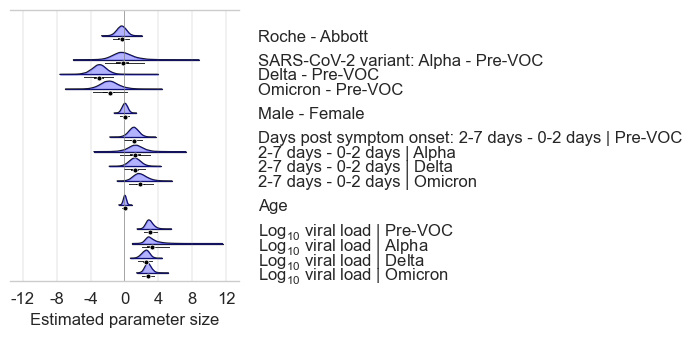

In [35]:
varNames1=("testDevice", "variant", "gender", "daysVariant", "zAge", "zVlVariant")
ax = ridgeForestPlot(iDataBmb1, varNames=varNames1, figsize=(colWidth*2, colWidth*1), xlim=(-13.5, 13.5),
                     fontsize=fontSizePlot)

plt.savefig(f"{plotDir}/FigureA3-B.pdf", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA3-B.png", dpi=600, bbox_inches="tight")

##### Spaghetti plots

In [121]:
predDictBmb1 = defaultdict(dict)

In [122]:
predictionsNewData(dfLogisticBmb1, bmbModel1, iDataBmb1, predDictBmb1, "variant", (0, 1, 2, 3))
predictionsNewData(dfLogisticBmb1, bmbModel1, iDataBmb1, predDictBmb1, "binDaysPostOnset", (0, 1))

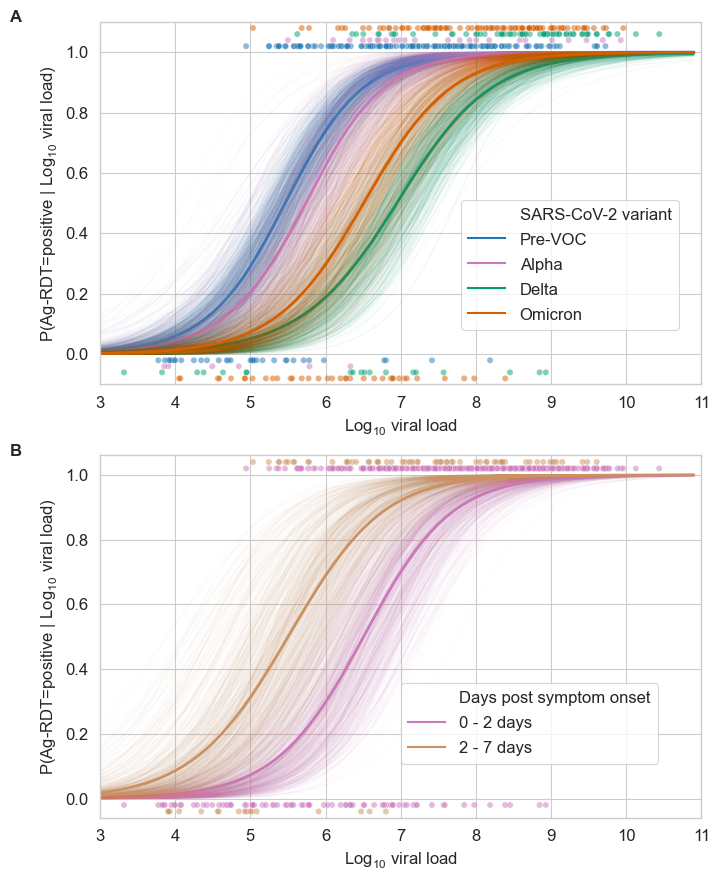

In [123]:
_, ax = plt.subplots(2, 1, figsize=(colWidth*2, colWidth*2.5))
ax1, ax2 = ax.flatten()

spaghettiPlotCategorical(ax1, "variant", (0, 1, 2, 3), predDictBmb1, dfLogisticBmb1, legendLoc=(0.6, 0.15))
spaghettiPlotCategorical(ax2, "binDaysPostOnset", (0, 1), predDictBmb1, dfLogisticBmb1)
plt.tight_layout()

for a in ax1, ax2:
    setFontSize(a, size=fontSizePlot) 
annotateWithLetters((ax1, ax2), size=fontSizePlot, coords=(-0.15, 1))

plt.savefig(f"{plotDir}/FigureA3_BSpagh.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA3_BSpagh.pdf", dpi=600, bbox_inches="tight")

### Additionally include variable for immunization status

In [146]:
indVars, zIndVars, indCatVars = logisticRegressionVars(immunVar="immun2YN")

In [147]:
formulaAllInd = f"agrdt ~ testDevice + immun2YN + variant + gender + binDaysPostOnset + (0 + binDaysPostOnset|immun2YN) + zVl + (0 + zVl|immun2YN) + zAge"
dfLogisticBmb2 = logisticRegressionDf(dfPos, immunVar="immun2YN")

# A temporary modification to see how the regression reacts when removing negative samples of unvaccinated delta/omicron persons.
mask1 = (dfLogisticBmb2.immun2YN==0) & dfLogisticBmb2.variant.isin((2, 3)) & (dfLogisticBmb2.agrdt==0)
dfLogisticBmb3 = dfLogisticBmb2[~(mask1)]

priors = {"zVl": bmb.Prior("Lognormal", mu=1, sigma=1),
          "zVl|immun2YN": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
          "binDaysPostOnset|immun2YN": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
          "testDevice": bmb.Prior("Normal", mu=-0.5, sigma=0.57),
          "zAge": bmb.Prior("Normal", mu=0, sigma=1),
          "gender": bmb.Prior("Normal", mu=0, sigma=1)}

bmbModel2 = bmb.Model(formulaAllInd, dfLogisticBmb2, priors=priors, family="bernoulli", categorical=list(indCatVars), noncentered=True)
bmbModel2.build()

bmbModel3 = bmb.Model(formulaAllInd, dfLogisticBmb3, priors=priors, family="bernoulli", categorical=list(indCatVars), noncentered=True)
bmbModel3.build()

In [150]:
maskNegPoints = (dfLogisticBmb2.immun2YN==0) & dfLogisticBmb2.variant.isin((2, 3)) & (dfLogisticBmb2.agrdt==0)
negPointsYCoords = dfLogisticBmb2[maskNegPoints].vl

In [153]:
def plotDataPointsRegression(df, negPointsYCoords, ax1, ax2):
    plotFigA4_left(df, palette=pal, label=label, ax=ax1, fontSizePlot=fontSizePlot)
    plotFigA4_right(df, negPointsYCoords, palette=pal, legend=legend, ax=ax2, fontSizePlot=fontSizePlot)

    fig.text(0.55, 0, label.immun2YN, va="center", ha="center", fontsize=fontSizePlot)

In [130]:
# Counts
dfPrevocAlpha = dfLogisticBmb2[dfLogisticBmb2.variant.isin((0, 1))].copy()
dfDeltaOmicron = dfLogisticBmb2[dfLogisticBmb2.variant.isin((2,3))]

In [131]:
print(f"Pre-Voc and Alpha (pos, neg): {dfPrevocAlpha.agrdt.value_counts().loc[1]}, {dfPrevocAlpha.agrdt.value_counts().loc[0]}")
print(f"Delta and Omicron, immune naive (pos, neg): {dfDeltaOmicron[dfDeltaOmicron.immun2YN==0].agrdt.value_counts().loc[1]}, {dfDeltaOmicron[dfDeltaOmicron.immun2YN==0].agrdt.value_counts().loc[0]}")
print(f"Delta and Omicron, immunized (pos, neg): {dfDeltaOmicron[dfDeltaOmicron.immun2YN==1].agrdt.value_counts().loc[1]}, {dfDeltaOmicron[dfDeltaOmicron.immun2YN==1].agrdt.value_counts().loc[0]}")

Pre-Voc and Alpha (pos, neg): 146, 30
Delta and Omicron, immune naive (pos, neg): 7, 2
Delta and Omicron, immunized (pos, neg): 142, 51


/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1815: UserWarning: FixedFormatter should only be used together with FixedLocator
  )
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1820: UserWarning: FixedFormatter should only be used together with FixedLocator
  xticklabels = ["no"]


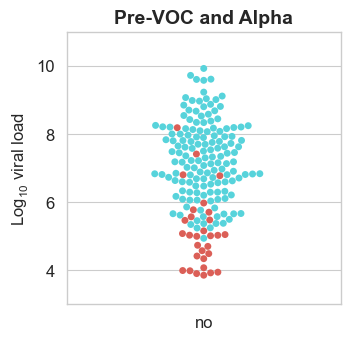

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(colWidth, colWidth))

plotFigA4_left(df=dfLogisticBmb2, palette=pal, label=label, ax=ax, fontSizePlot=fontSizePlot)

plt.savefig(f"{plotDir}/FigureA4_left.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA4_left.pdf", dpi=600, bbox_inches="tight")

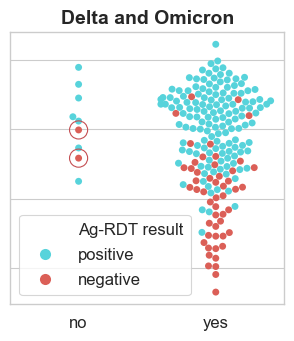

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(colWidth, colWidth))

plotFigA4_right(dfLogisticBmb2, negPointsYCoords, palette=pal, legend=legend, ax=ax, fontSizePlot=fontSizePlot)

ax.set_yticklabels("")

plt.savefig(f"{plotDir}/FigureA4_right.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA4_right.pdf", dpi=600, bbox_inches="tight")

/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1815: UserWarning: FixedFormatter should only be used together with FixedLocator
  )
/Users/leoniemeiners/virology/projects/agrdt-study/utils/plotUtils.py:1820: UserWarning: FixedFormatter should only be used together with FixedLocator
  xticklabels = ["no"]


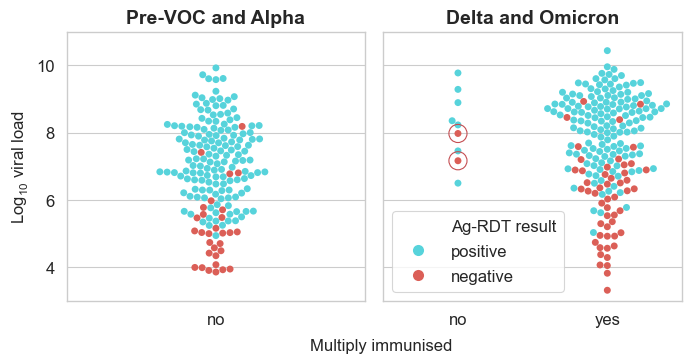

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(2*colWidth, colWidth), sharey=True)
ax1, ax2 = ax.flatten()

plotDataPointsRegression(dfLogisticBmb2, negPointsYCoords, ax1, ax2)

plt.tight_layout()

plt.savefig(f"{plotDir}/FigureA4.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA4.pdf", dpi=600, bbox_inches="tight")

#### Using all data points

In [135]:
bmbModel2

Formula: agrdt ~ testDevice + immun2YN + variant + gender + binDaysPostOnset + (0 + binDaysPostOnset|immun2YN) + zVl + (0 + zVl|immun2YN) + zAge
Family name: Bernoulli
Link: logit
Observations: 378
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.3853)
    testDevice ~ Normal(mu: -0.5, sigma: 0.57)
    immun2YN ~ Normal(mu: 0.0, sigma: 5.0011)
    variant ~ Normal(mu: [0. 0. 0.], sigma: [11.4422  6.3332  5.2728])
    gender ~ Normal(mu: 0, sigma: 1)
    binDaysPostOnset ~ Normal(mu: 0.0, sigma: 6.4718)
    zVl ~ Lognormal(mu: 1, sigma: 1)
    zAge ~ Normal(mu: 0, sigma: 1)

  Group-level effects
    binDaysPostOnset|immun2YN ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))
    zVl|immun2YN ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))

In [36]:
iDataFigA3C = Path(iDataDir, "figA3C.nc")
if iDataFigA3C.exists():
    iDataBmb2 = az.from_netcdf(iDataFigA3C)
else:
    iDataBmb2 = bmbModel2.fit(target_accept=0.99, draws=10000, tune=4000, random_seed=SEED)

In [342]:
iDataBmb2.to_netcdf(iDataFigA3C)

'../output/iData/figA3C.nc'

##### Posterior analysis

##### Process binDaysPostOnset|immun2YN

In [37]:
zVl = iDataBmb2.posterior["zVl"]

In [38]:
immunNo_zVl = iDataBmb2.posterior.sel(immun2YN__factor_dim="0")["zVl|immun2YN"] + zVl
immunYes_zVl = iDataBmb2.posterior.sel(immun2YN__factor_dim="1")["zVl|immun2YN"] + zVl

In [39]:
zVlimmun2YN = xarray.concat([immunNo_zVl, immunYes_zVl], dim="zVlImmun2YN_dim")
zVlimmun2YN.name="zVlImmun2YN"

In [40]:
iDataBmb2.posterior["zVlImmun2YN"] = zVlimmun2YN

##### Process zVl|immun2YN

In [41]:
daysPostOnset = iDataBmb2.posterior.sel(binDaysPostOnset_dim="1")["binDaysPostOnset"]

In [42]:
vaccNo_days1 = iDataBmb2.posterior.sel(immun2YN__factor_dim="0", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|immun2YN"]
vaccNo_days2 = iDataBmb2.posterior.sel(immun2YN__factor_dim="0", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|immun2YN"]
vaccNo_diff = vaccNo_days2 - vaccNo_days1 + daysPostOnset

vaccYes_days1 = iDataBmb2.posterior.sel(immun2YN__factor_dim="1", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|immun2YN"]
vaccYes_days2 = iDataBmb2.posterior.sel(immun2YN__factor_dim="1", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|immun2YN"]
vaccYes_diff = vaccYes_days2 - vaccYes_days1 + daysPostOnset

In [43]:
days_immun2YN = xarray.concat([vaccNo_diff, vaccYes_diff], dim="daysImmun2YN_dim")
days_immun2YN.name="daysImmun2YN"

In [44]:
iDataBmb2.posterior["daysImmun2YN"] = days_immun2YN

##### Trace plot

/Users/leoniemeiners/miniconda3/envs/agrdt-study/lib/python3.10/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['agrdt_mean'] have not been found and will be ignored
  warnings.warn(


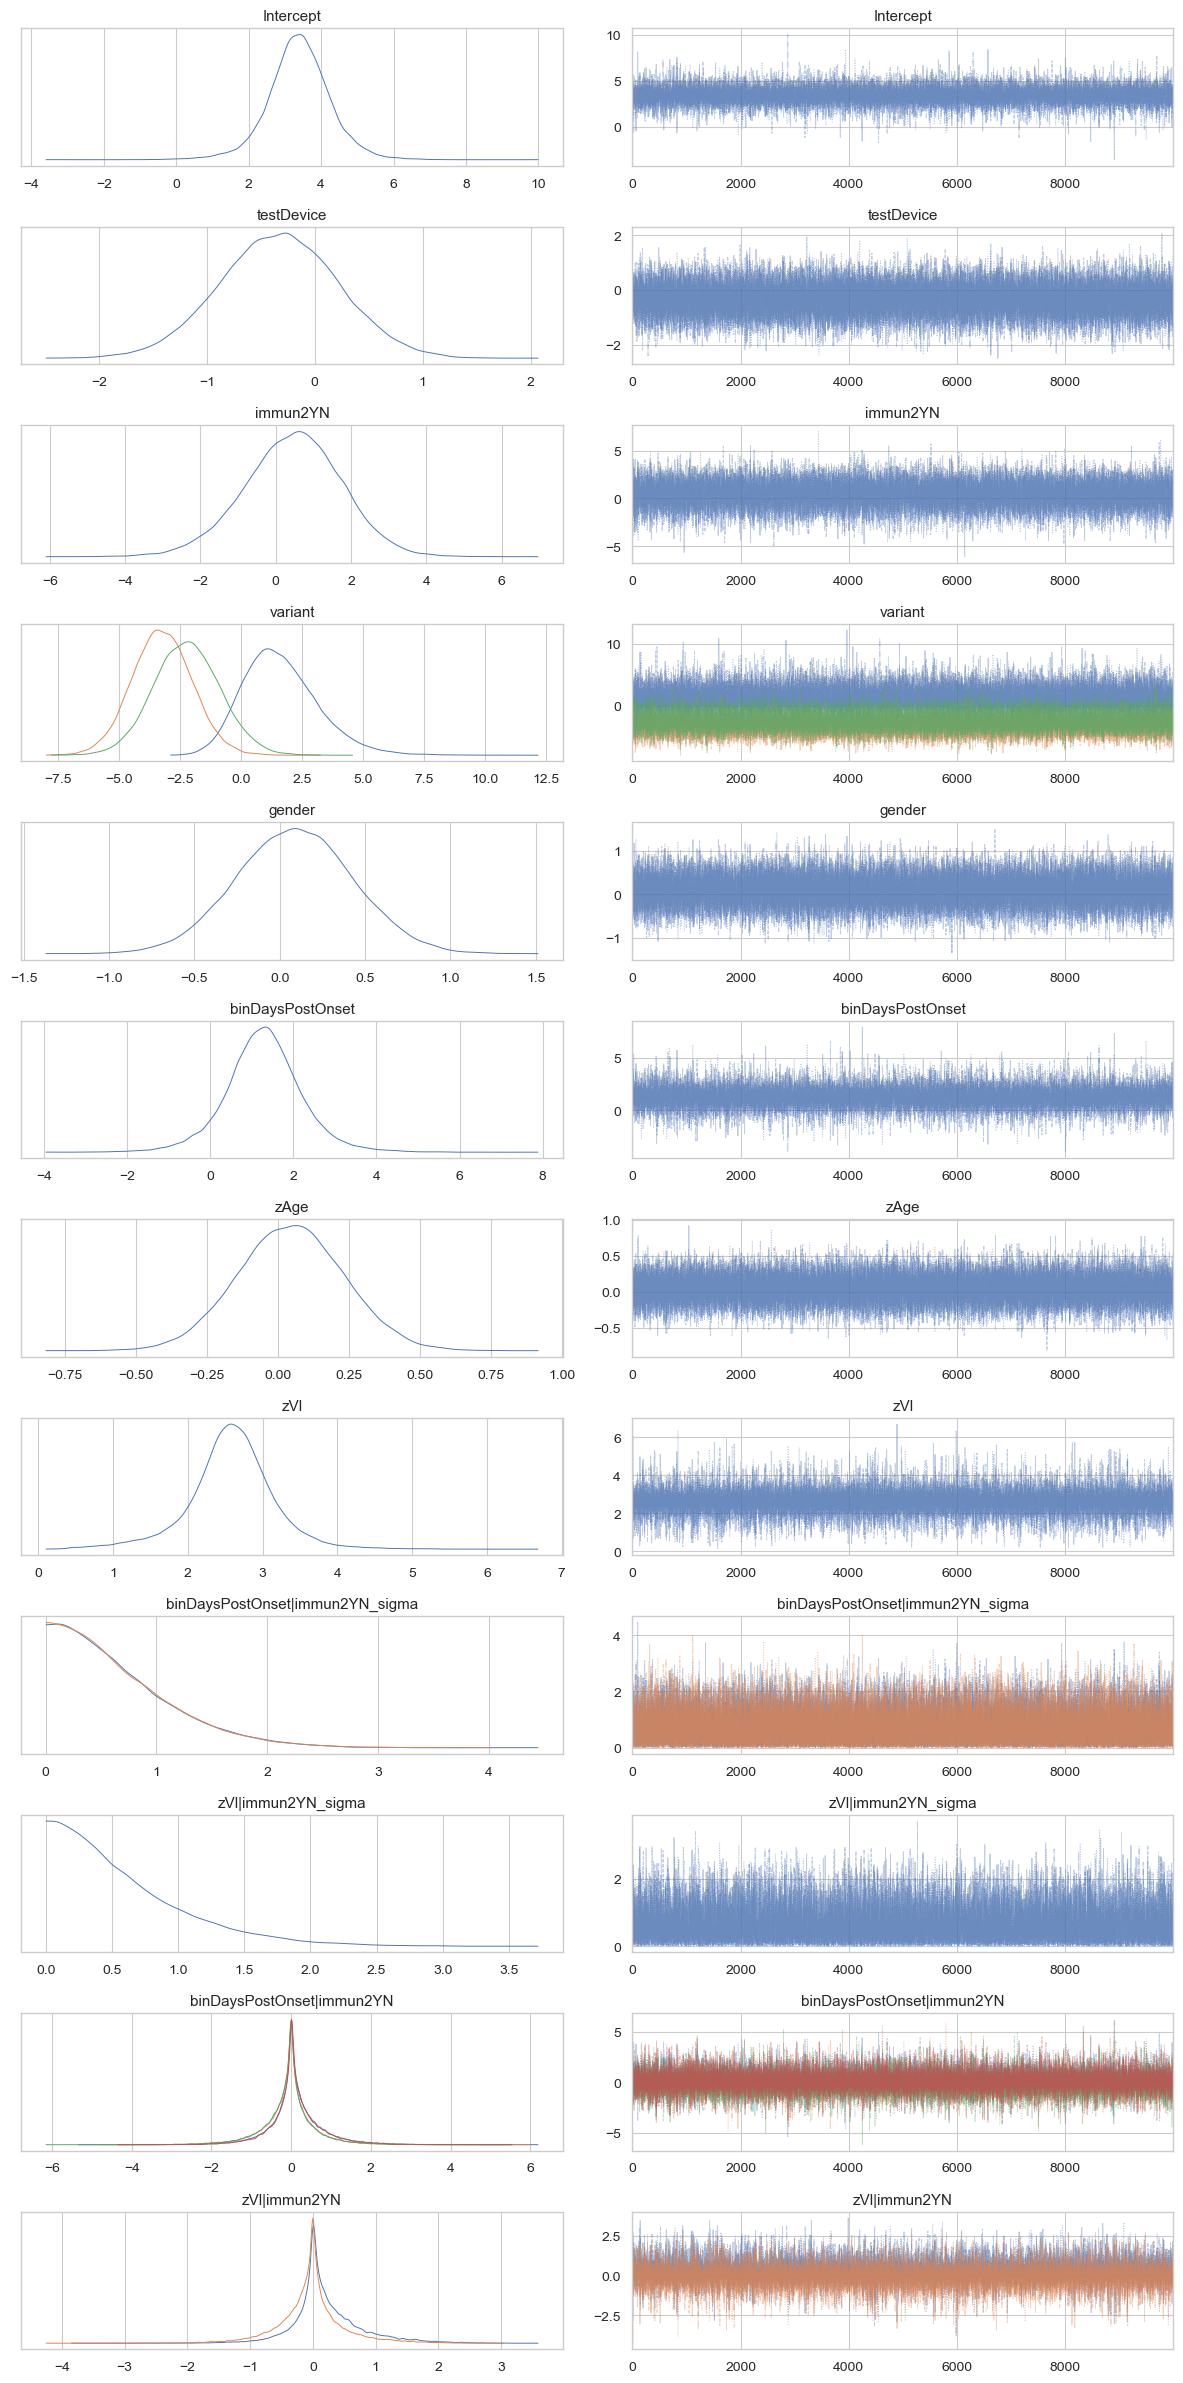

In [145]:
az.plot_trace(iDataBmb2, combined=True, var_names=["~zVlImmun2YN", "~daysImmun2YN", "~agrdt_mean"]);
plt.tight_layout()

In [146]:
pd.set_option("display.max_rows", 50)

In [147]:
az.summary(iDataBmb2)

mean   sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                           3.38 0.88    1.78     5.13       0.01   
testDevice[1]                      -0.34 0.55   -1.37     0.70       0.00   
immun2YN[1]                         0.45 1.30   -2.03     2.87       0.01   
variant[1]                          1.61 1.55   -1.12     4.55       0.01   
variant[2]                         -3.23 1.23   -5.52    -0.90       0.01   
variant[3]                         -2.21 1.36   -4.71     0.42       0.01   
gender[1]                           0.09 0.34   -0.55     0.74       0.00   
binDaysPostOnset[1]                 1.29 0.94   -0.54     3.08       0.01   
zAge                                0.05 0.19   -0.31     0.40       0.00   
zVl                                 2.58 0.58    1.42     3.73       0.00   
binDaysPostOnset|immun2YN_sigma[0]  0.66 0.52    0.00     1.62       0.00   
binDaysPostOnset|immun2YN_sigma[1]  0.65 0.52    0.00     1.60       0.00   
zVl|immun2YN_sigma                  0.58 0.49    0.00     1.50       0.00   
binDaysPostOnset|immun2YN[0, 0]     0.10 0.69   -1.20     1.59       0.01   
binDaysPostOnset|immun2YN[0, 1]    -0.05 0.68   -1.43     1.30       0.01   
binDaysPostOnset|immun2YN[1, 0]    -0.06 0.68   -1.47     1.30       0.00   
binDaysPostOnset|immun2YN[1, 1]     0.10 0.68   -1.24     1.53       0.00   
zVl|immun2YN[0]                     0.20 0.57   -0.80     1.47       0.00   
zVl|immun2YN[1]                    -0.03 0.55   -1.12     1.14       0.00   
zVlImmun2YN[0]                      2.78 0.41    2.03     3.57       0.00   
zVlImmun2YN[1]                      2.55 0.34    1.90     3.17       0.00   
daysImmun2YN[0]                     1.13 0.60    0.00     2.26       0.00   
daysImmun2YN[1]                     1.45 0.62    0.33     2.64       0.00   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                              0.00  20455.00  19302.00   1.00  
testDevice[1]                          0.00  34405.00  28004.00   1.00  
immun2YN[1]                            0.01  21968.00  23204.00   1.00  
variant[1]                             0.01  28902.00  20129.00   1.00  
variant[2]                             0.01  22039.00  23605.00   1.00  
variant[3]                             0.01  20255.00  23523.00   1.00  
gender[1]                              0.00  37491.00  29564.00   1.00  
binDaysPostOnset[1]                    0.01  19051.00  18601.00   1.00  
zAge                                   0.00  41592.00  28506.00   1.00  
zVl                                    0.00  20521.00  12983.00   1.00  
binDaysPostOnset|immun2YN_sigma[0]     0.00  19216.00  18084.00   1.00  
binDaysPostOnset|immun2YN_sigma[1]     0.00  20880.00  17319.00   1.00  
zVl|immun2YN_sigma                     0.00  19696.00  18500.00   1.00  
binDaysPostOnset|immun2YN[0, 0]        0.00  18933.00  18072.00   1.00  
binDaysPostOnset|immun2YN[0, 1]        0.00  19098.00  18486.00   1.00  
binDaysPostOnset|immun2YN[1, 0]        0.00  25953.00  25435.00   1.00  
binDaysPostOnset|immun2YN[1, 1]        0.00  25607.00  25627.00   1.00  
zVl|immun2YN[0]                        0.00  20406.00  16375.00   1.00  
zVl|immun2YN[1]                        0.00  19967.00  14541.00   1.00  
zVlImmun2YN[0]                         0.00  42512.00  35777.00   1.00  
zVlImmun2YN[1]                         0.00  47347.00  37312.00   1.00  
daysImmun2YN[0]                        0.00  49632.00  37288.00   1.00  
daysImmun2YN[1]                        0.00  48653.00  36343.00   1.00

##### Forest plot

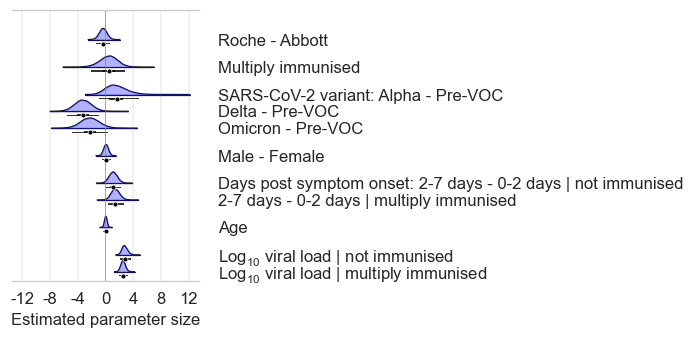

In [45]:
varNames1=("testDevice", "immun2YN", "variant", "gender", "daysImmun2YN", "zAge", "zVlImmun2YN")
ax = ridgeForestPlot(iDataBmb2, varNames=varNames1, figsize=(colWidth*2, colWidth*1), xlim=(-13.5, 13.5),
                     fontsize=fontSizePlot)


plt.savefig(f"{plotDir}/FigureA3-C.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA3-C.pdf", dpi=600, bbox_inches="tight")

#### Removing the two Ag-RDT negative samples in the Delta/Omicron immune naive group

In [149]:
bmbModel3

Formula: agrdt ~ testDevice + immun2YN + variant + gender + binDaysPostOnset + (0 + binDaysPostOnset|immun2YN) + zVl + (0 + zVl|immun2YN) + zAge
Family name: Bernoulli
Link: logit
Observations: 376
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.3915)
    testDevice ~ Normal(mu: -0.5, sigma: 0.57)
    immun2YN ~ Normal(mu: 0.0, sigma: 5.0018)
    variant ~ Normal(mu: [0. 0. 0.], sigma: [11.4135  6.3537  5.2759])
    gender ~ Normal(mu: 0, sigma: 1)
    binDaysPostOnset ~ Normal(mu: 0.0, sigma: 6.4585)
    zVl ~ Lognormal(mu: 1, sigma: 1)
    zAge ~ Normal(mu: 0, sigma: 1)

  Group-level effects
    binDaysPostOnset|immun2YN ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))
    zVl|immun2YN ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))

In [46]:
iDataFigA3D = Path(iDataDir, "figA3D.nc")
if iDataFigA3D.exists():
    iDataBmb3 = az.from_netcdf(iDataFigA3D)
else:
    iDataBmb3 = bmbModel3.fit(target_accept=0.99, draws=10000, tune=4000, random_seed=SEED)#draws=10000, tune=4000)

In [343]:
iDataBmb3.to_netcdf(iDataFigA3D)

'../output/iData/figA3D.nc'

##### Posterior analysis

##### Process binDaysPostOnset|immun2YN

In [47]:
zVl = iDataBmb3.posterior["zVl"]

In [48]:
immunNo_zVl = iDataBmb3.posterior.sel(immun2YN__factor_dim="0")["zVl|immun2YN"] + zVl
immunYes_zVl = iDataBmb3.posterior.sel(immun2YN__factor_dim="1")["zVl|immun2YN"] + zVl

In [49]:
zVlimmun2YN = xarray.concat([immunNo_zVl, immunYes_zVl], dim="zVlImmun2YN_dim")
zVlimmun2YN.name="zVlImmun2YN"

In [50]:
iDataBmb3.posterior["zVlImmun2YN"] = zVlimmun2YN

##### Process zVl|immun2YN

In [51]:
daysPostOnset = iDataBmb3.posterior.sel(binDaysPostOnset_dim="1")["binDaysPostOnset"]

In [52]:
vaccNo_days1 = iDataBmb3.posterior.sel(immun2YN__factor_dim="0", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|immun2YN"]
vaccNo_days2 = iDataBmb3.posterior.sel(immun2YN__factor_dim="0", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|immun2YN"]
vaccNo_diff = vaccNo_days2 - vaccNo_days1 + daysPostOnset

vaccYes_days1 = iDataBmb3.posterior.sel(immun2YN__factor_dim="1", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|immun2YN"]
vaccYes_days2 = iDataBmb3.posterior.sel(immun2YN__factor_dim="1", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|immun2YN"]
vaccYes_diff = vaccYes_days2 - vaccYes_days1 + daysPostOnset

In [53]:
days_immun2YN = xarray.concat([vaccNo_diff, vaccYes_diff], dim="daysImmun2YN-dim")
days_immun2YN.name="daysImmun2YN"

In [54]:
iDataBmb3.posterior["daysImmun2YN"] = days_immun2YN

##### Trace plot

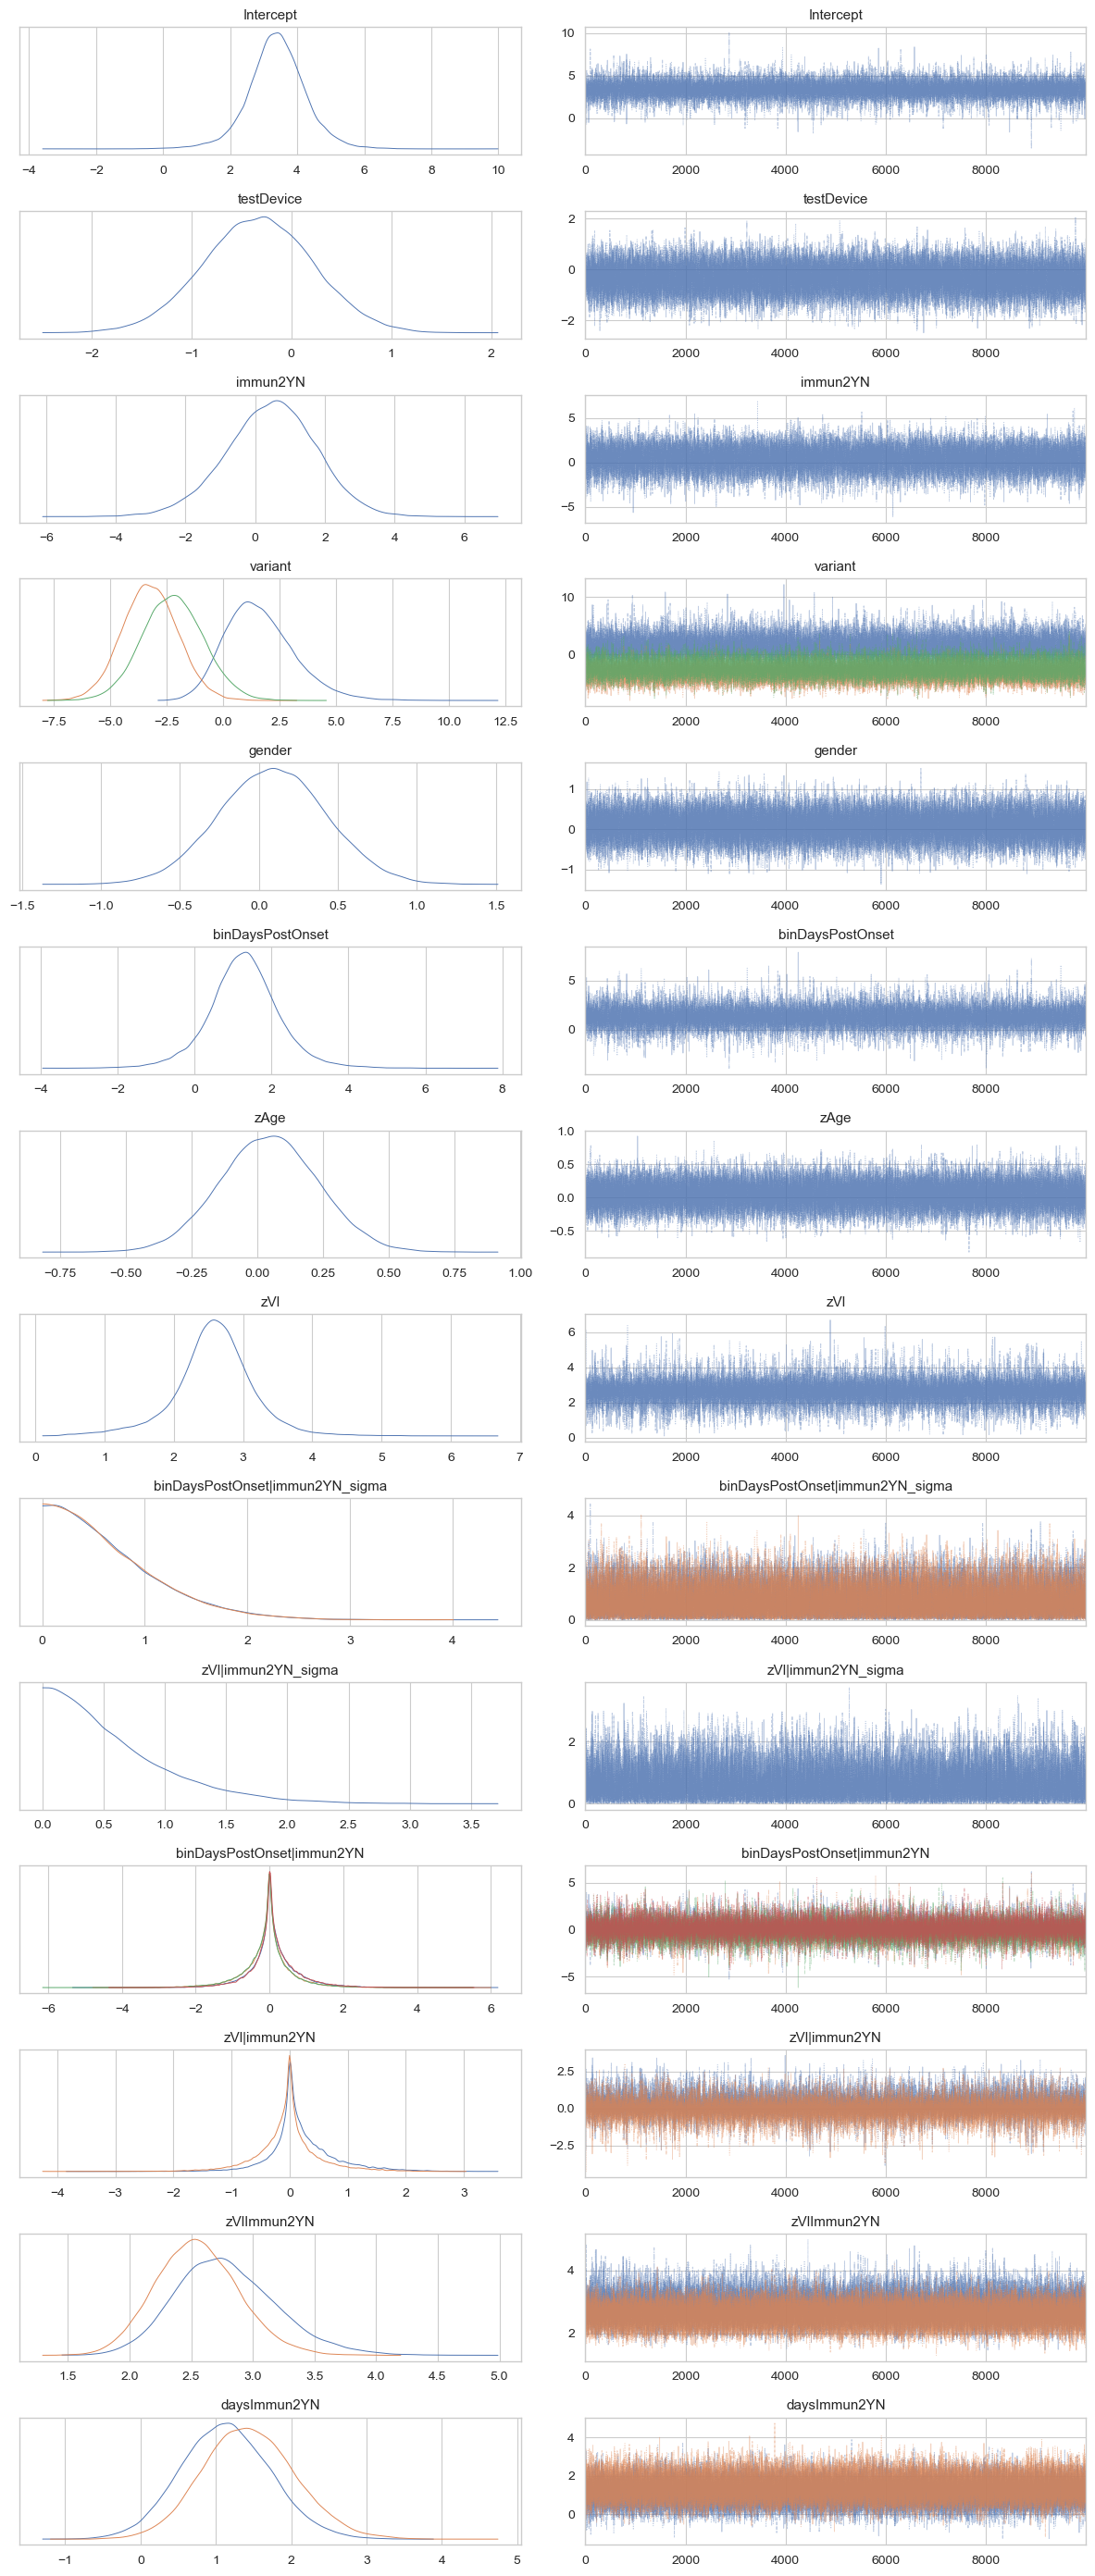

In [159]:
az.plot_trace(iDataBmb2, combined=True);
plt.tight_layout()

In [160]:
pd.set_option("display.max_rows", 50)

In [161]:
az.summary(iDataBmb3)

mean   sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                           3.44 0.92    1.68     5.21       0.01   
testDevice[1]                      -0.28 0.55   -1.33     0.74       0.00   
immun2YN[1]                        -3.52 2.30   -7.93     0.62       0.01   
variant[1]                          1.63 1.56   -1.13     4.62       0.01   
variant[2]                          0.61 2.25   -3.43     4.86       0.01   
variant[3]                          1.73 2.30   -2.35     6.14       0.01   
gender[1]                           0.16 0.35   -0.48     0.82       0.00   
binDaysPostOnset[1]                 1.30 0.97   -0.51     3.23       0.01   
zAge                                0.06 0.19   -0.30     0.42       0.00   
zVl                                 2.67 0.61    1.42     3.82       0.00   
binDaysPostOnset|immun2YN_sigma[0]  0.68 0.54    0.00     1.64       0.00   
binDaysPostOnset|immun2YN_sigma[1]  0.67 0.53    0.00     1.62       0.00   
zVl|immun2YN_sigma                  0.62 0.50    0.00     1.53       0.00   
binDaysPostOnset|immun2YN[0, 0]     0.17 0.72   -1.10     1.76       0.01   
binDaysPostOnset|immun2YN[0, 1]    -0.10 0.70   -1.57     1.25       0.01   
binDaysPostOnset|immun2YN[1, 0]    -0.07 0.70   -1.65     1.24       0.00   
binDaysPostOnset|immun2YN[1, 1]     0.10 0.71   -1.27     1.57       0.00   
zVl|immun2YN[0]                     0.24 0.60   -0.76     1.62       0.00   
zVl|immun2YN[1]                    -0.07 0.57   -1.22     1.13       0.00   
zVlImmun2YN[0]                      2.92 0.45    2.08     3.76       0.00   
zVlImmun2YN[1]                      2.60 0.35    1.98     3.29       0.00   
daysImmun2YN[0]                     1.06 0.62   -0.09     2.25       0.00   
daysImmun2YN[1]                     1.50 0.63    0.32     2.70       0.00   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                              0.00  26383.00  23021.00   1.00  
testDevice[1]                          0.00  55424.00  28787.00   1.00  
immun2YN[1]                            0.01  25251.00  22587.00   1.00  
variant[1]                             0.01  44899.00  21599.00   1.00  
variant[2]                             0.01  24896.00  22323.00   1.00  
variant[3]                             0.01  25033.00  22688.00   1.00  
gender[1]                              0.00  48523.00  28776.00   1.00  
binDaysPostOnset[1]                    0.01  22917.00  22478.00   1.00  
zAge                                   0.00  48889.00  29072.00   1.00  
zVl                                    0.00  21848.00  13061.00   1.00  
binDaysPostOnset|immun2YN_sigma[0]     0.00  21113.00  15710.00   1.00  
binDaysPostOnset|immun2YN_sigma[1]     0.00  22478.00  14343.00   1.00  
zVl|immun2YN_sigma                     0.00  21121.00  18581.00   1.00  
binDaysPostOnset|immun2YN[0, 0]        0.00  23588.00  22822.00   1.00  
binDaysPostOnset|immun2YN[0, 1]        0.00  23873.00  22654.00   1.00  
binDaysPostOnset|immun2YN[1, 0]        0.00  30712.00  28077.00   1.00  
binDaysPostOnset|immun2YN[1, 1]        0.00  30711.00  28751.00   1.00  
zVl|immun2YN[0]                        0.00  22701.00  16817.00   1.00  
zVl|immun2YN[1]                        0.00  21314.00  14876.00   1.00  
zVlImmun2YN[0]                         0.00  46563.00  34270.00   1.00  
zVlImmun2YN[1]                         0.00  44121.00  36020.00   1.00  
daysImmun2YN[0]                        0.00  47376.00  38269.00   1.00  
daysImmun2YN[1]                        0.00  49513.00  37333.00   1.00

##### Forest plot

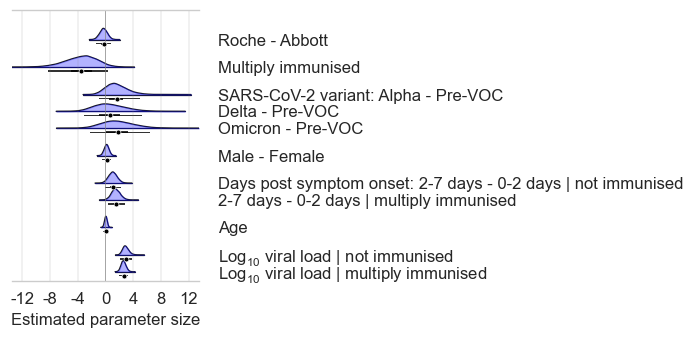

In [55]:
varNames1=("testDevice", "immun2YN", "variant", "gender", "daysImmun2YN", "zAge", "zVlImmun2YN")
ax = ridgeForestPlot(iDataBmb3, varNames=varNames1, figsize=(colWidth*2, colWidth*1), xlim=(-13.5, 13.5),
                     fontsize=fontSizePlot)

plt.savefig(f"{plotDir}/FigureA3-D.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA3-D.pdf", dpi=300, bbox_inches="tight")

### Replacing variant variable with immunization status variable

In [15]:
indVars, zIndVars, _= logisticRegressionVars(immunVar="immun2YN")
indCatVars = ("testDevice", "immun2YN", "gender", "binDaysPostOnset")

In [16]:
formulaAllInd = f"agrdt ~ testDevice + immun2YN + gender + binDaysPostOnset + (0 + binDaysPostOnset|immun2YN) + zVl + (0 + zVl|immun2YN) + zAge"

dfLogisticBmb4 = logisticRegressionDf(dfPos, indCatVars=indCatVars, immunVar="immun2YN")
priors = {"zVl": bmb.Prior("Lognormal", mu=1, sigma=1),
          "zVl|immun2YN": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
          "binDaysPostOnset|immun2YN": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
          "testDevice": bmb.Prior("Normal", mu=-0.5, sigma=0.5),
          "zAge": bmb.Prior("Normal", mu=0, sigma=1),
          "gender": bmb.Prior("Normal", mu=0, sigma=1)}
bmbModel4 = bmb.Model(formulaAllInd, dfLogisticBmb4, priors=priors, family="bernoulli", 
                      categorical=list(indCatVars), noncentered=True) #, dropna=True)
bmbModel4.build()

In [17]:
bmbModel4

Formula: agrdt ~ testDevice + immun2YN + gender + binDaysPostOnset + (0 + binDaysPostOnset|immun2YN) + zVl + (0 + zVl|immun2YN) + zAge
Family name: Bernoulli
Link: logit
Observations: 402
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.8074)
    testDevice ~ Normal(mu: -0.5, sigma: 0.5)
    immun2YN ~ Normal(mu: 0.0, sigma: 5.005)
    gender ~ Normal(mu: 0, sigma: 1)
    binDaysPostOnset ~ Normal(mu: 0.0, sigma: 6.4508)
    zVl ~ Lognormal(mu: 1, sigma: 1)
    zAge ~ Normal(mu: 0, sigma: 1)

  Group-level effects
    binDaysPostOnset|immun2YN ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))
    zVl|immun2YN ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))

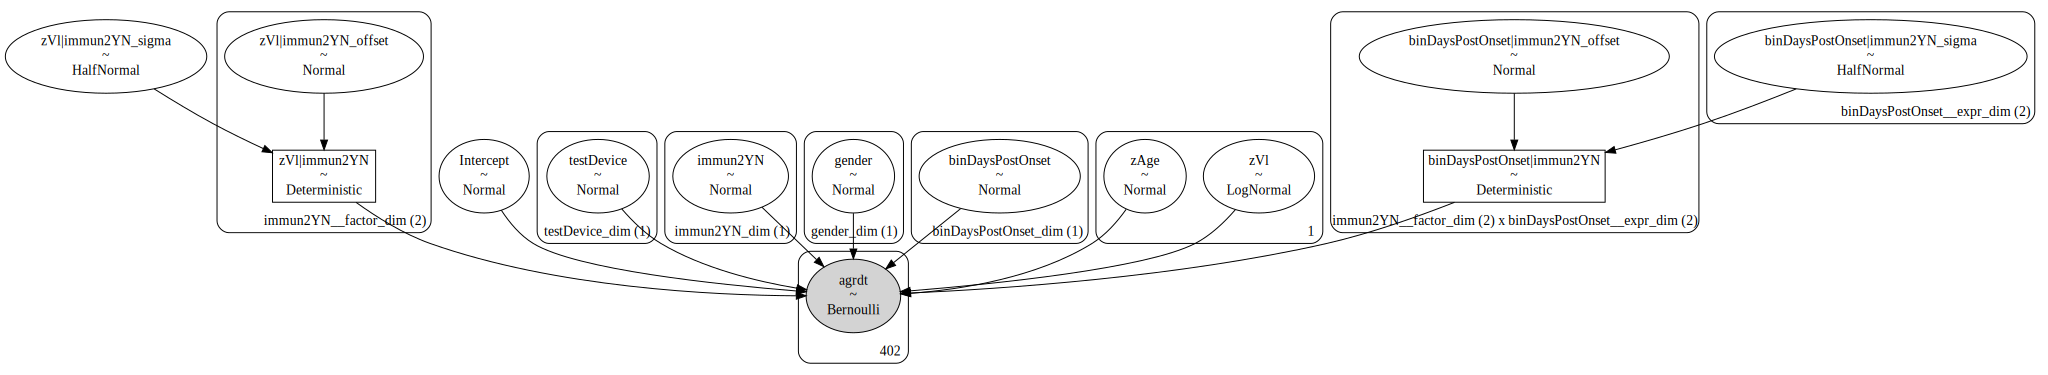

In [166]:
bmbModel4.graph()

In [18]:
iDataFigA3A = Path(iDataDir, "figA3A.nc")
if iDataFigA3A.exists():
    iDataBmb4 = az.from_netcdf(iDataFigA3A)
else:
    iDataBmb4 = bmbModel4.fit(target_accept=0.99, draws=10000, tune=4000, random_seed=SEED)

In [344]:
iDataBmb4.to_netcdf(iDataFigA3A)

'../output/iData/figA3A.nc'

#### Posterior analysis

##### Trace plot

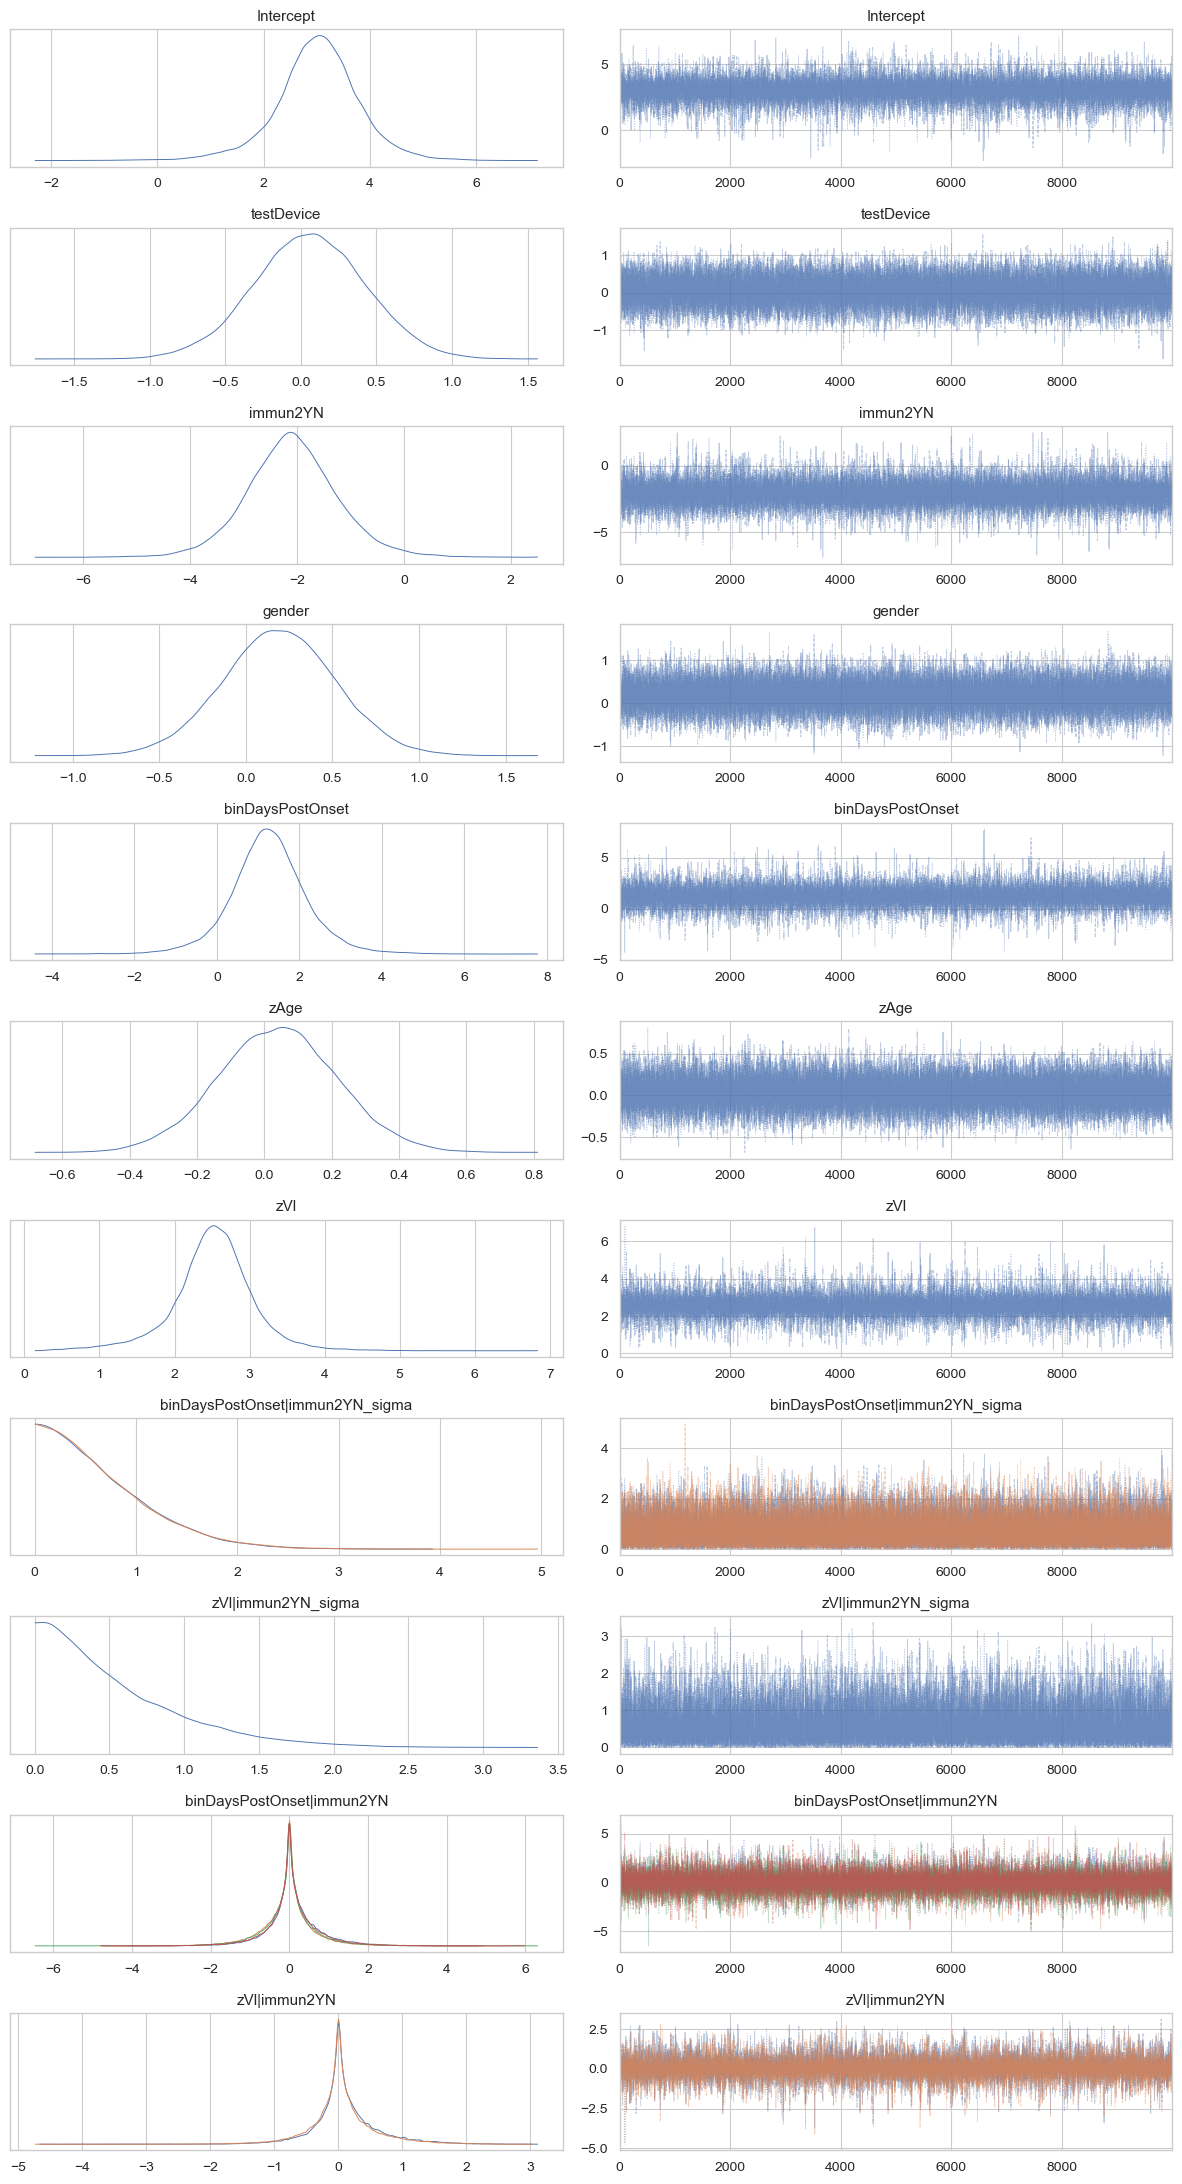

In [168]:
az.plot_trace(iDataBmb4, combined=True);
plt.tight_layout()

##### Process zVl|immun2YN

In [57]:
zVl = iDataBmb4.posterior["zVl"]

In [58]:
vaccNo_zVl = iDataBmb4.posterior.sel(immun2YN__factor_dim="0")["zVl|immun2YN"] + zVl
vaccYes_zVl = iDataBmb4.posterior.sel(immun2YN__factor_dim="1")["zVl|immun2YN"] + zVl

In [59]:
zVlImmun2YN = xarray.concat([vaccNo_zVl, vaccYes_zVl], dim="zVlImmun2YN_dim")
zVlImmun2YN.name="zVlImmun2YN"

In [60]:
iDataBmb4.posterior["zVlImmun2YN"] = zVlimmun2YN

##### Process binDaysPostOnset|immun2YN

In [61]:
daysPostOnset = iDataBmb4.posterior.sel(binDaysPostOnset_dim="1")["binDaysPostOnset"]

In [62]:
vaccNo_days1 = iDataBmb4.posterior.sel(immun2YN__factor_dim="0", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|immun2YN"]
vaccNo_days2 = iDataBmb4.posterior.sel(immun2YN__factor_dim="0", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|immun2YN"]
vaccNo_diff = vaccNo_days2 - vaccNo_days1 + daysPostOnset

vaccYes_days1 = iDataBmb4.posterior.sel(immun2YN__factor_dim="1", binDaysPostOnset__expr_dim="0")["binDaysPostOnset|immun2YN"]
vaccYes_days2 = iDataBmb4.posterior.sel(immun2YN__factor_dim="1", binDaysPostOnset__expr_dim="1")["binDaysPostOnset|immun2YN"]
vaccYes_diff = vaccYes_days2 - vaccYes_days1 + daysPostOnset

In [63]:
days_immun2YN = xarray.concat([vaccNo_diff, vaccYes_diff], dim="daysImmun2YN_dim")
days_immun2YN.name="daysImmun2YN"

In [64]:
iDataBmb4.posterior["daysImmun2YN"] = days_immun2YN

In [177]:
pd.set_option("display.max_rows", 160)

In [144]:
varNames1=("testDevice", "immun2YN", "gender", "daysImmun2YN", "zAge", "zVlImmun2YN")

summaryDf4 = az.summary(iDataBmb4, var_names="~agrdt_mean")
writeIDataSummaryTable(summaryDf4, varnames=varNames1, outfile=Path(tableDirResubmission2_2, "iDataSummary.tsv"))

/Users/leoniemeiners/miniconda3/envs/agrdt-study/lib/python3.10/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['agrdt_mean'] have not been found and will be ignored
  warnings.warn(


In [97]:
summaryDf4

mean   sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                           3.01 0.81    1.47     4.59       0.01   
testDevice[1]                       0.06 0.37   -0.63     0.76       0.00   
immun2YN[1]                        -2.09 0.87   -3.73    -0.43       0.01   
gender[1]                           0.19 0.33   -0.43     0.80       0.00   
binDaysPostOnset[1]                 1.25 0.94   -0.52     3.11       0.01   
zAge                                0.04 0.18   -0.29     0.38       0.00   
zVl                                 2.52 0.55    1.40     3.58       0.01   
binDaysPostOnset|immun2YN_sigma[0]  0.65 0.52    0.00     1.58       0.00   
binDaysPostOnset|immun2YN_sigma[1]  0.65 0.52    0.00     1.60       0.00   
zVl|immun2YN_sigma                  0.54 0.47    0.00     1.41       0.00   
binDaysPostOnset|immun2YN[0, 0]     0.11 0.68   -1.18     1.59       0.01   
binDaysPostOnset|immun2YN[0, 1]    -0.04 0.67   -1.42     1.31       0.01   
binDaysPostOnset|immun2YN[1, 0]    -0.03 0.68   -1.39     1.37       0.01   
binDaysPostOnset|immun2YN[1, 1]     0.06 0.69   -1.27     1.52       0.01   
zVl|immun2YN[0]                     0.10 0.52   -0.84     1.28       0.01   
zVl|immun2YN[1]                     0.05 0.52   -0.93     1.18       0.01   
zVlImmun2YN[0]                      2.92 0.45    2.08     3.76       0.00   
zVlImmun2YN[1]                      2.60 0.35    1.98     3.29       0.00   
daysImmun2YN[0]                     1.11 0.58    0.02     2.19       0.00   
daysImmun2YN[1]                     1.35 0.60    0.22     2.47       0.00   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                              0.01  17137.00  15465.00   1.00  
testDevice[1]                          0.00  37933.00  31177.00   1.00  
immun2YN[1]                            0.00  21961.00  21675.00   1.00  
gender[1]                              0.00  36549.00  29615.00   1.00  
binDaysPostOnset[1]                    0.01  15914.00  16107.00   1.00  
zAge                                   0.00  43054.00  30153.00   1.00  
zVl                                    0.00  14537.00   8820.00   1.00  
binDaysPostOnset|immun2YN_sigma[0]     0.00  14492.00  14019.00   1.00  
binDaysPostOnset|immun2YN_sigma[1]     0.00  17478.00  14960.00   1.00  
zVl|immun2YN_sigma                     0.00  16423.00  17696.00   1.00  
binDaysPostOnset|immun2YN[0, 0]        0.00  15198.00  15331.00   1.00  
binDaysPostOnset|immun2YN[0, 1]        0.00  15525.00  15042.00   1.00  
binDaysPostOnset|immun2YN[1, 0]        0.00  20878.00  21570.00   1.00  
binDaysPostOnset|immun2YN[1, 1]        0.00  22649.00  23260.00   1.00  
zVl|immun2YN[0]                        0.00  14879.00  10944.00   1.00  
zVl|immun2YN[1]                        0.00  14444.00  10150.00   1.00  
zVlImmun2YN[0]                         0.00  46563.00  34270.00   1.00  
zVlImmun2YN[1]                         0.00  44121.00  36020.00   1.00  
daysImmun2YN[0]                        0.00  47454.00  36549.00   1.00  
daysImmun2YN[1]                        0.00  50113.00  37292.00   1.00

##### Forest plot

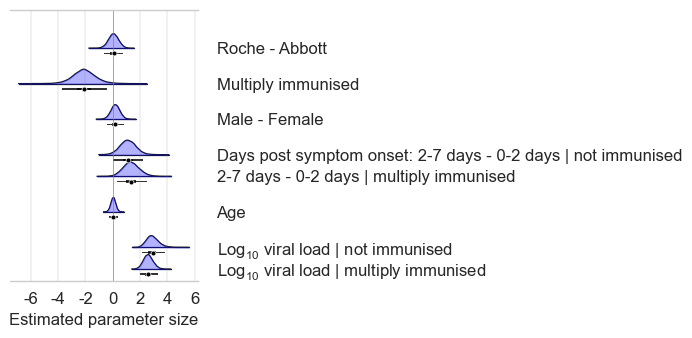

In [143]:
varNames1=("testDevice", "immun2YN", "gender", "daysImmun2YN", "zAge", "zVlImmun2YN")
ax = ridgeForestPlot(iDataBmb4, varNames=varNames1, figsize=(colWidth*2, colWidth*1), fontsize=fontSizePlot)
ax.tick_params(axis="y", which="both", labelleft=False, labelright=True)

plt.savefig(f"{plotDir}/FigureA3-A.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA3-A.pdf", dpi=600, bbox_inches="tight")

plt.savefig(f"{plotDir}/Figure4.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure4.pdf", dpi=600, bbox_inches="tight")

##### Spaghetti plots (Figure 5)

In [14]:
predDictBmb4 = defaultdict(dict)

In [19]:
predictionsNewData(dfLogisticBmb4, bmbModel4, iDataBmb4, predDictBmb4, "immun2YN", (0, 1))
predictionsNewData(dfLogisticBmb4, bmbModel4, iDataBmb4, predDictBmb4, "binDaysPostOnset", (0, 1))

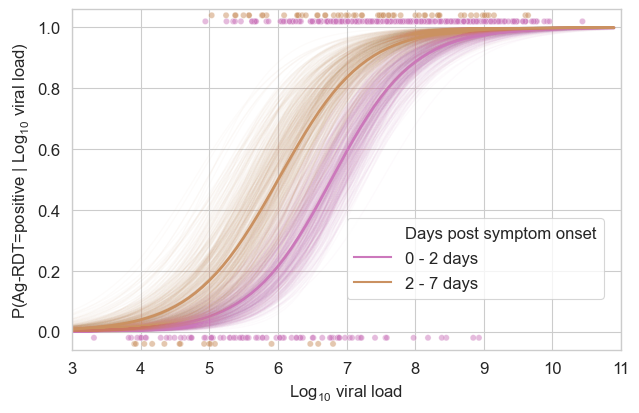

In [20]:
_, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth*1.25))
spaghettiPlotCategorical(ax, "binDaysPostOnset", (0, 1), predDictBmb4, dfLogisticBmb4)
setFontSize(ax, size=fontSizePlot)

plt.savefig(f"{plotDir}/Figure5-A.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure5-A.pdf", dpi=600, bbox_inches="tight")

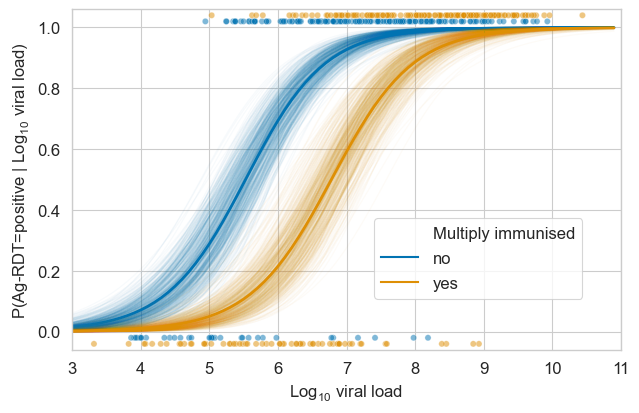

In [21]:
_, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth*1.25))
spaghettiPlotCategorical(ax, "immun2YN", (0, 1), predDictBmb4, dfLogisticBmb4, legendLoc=(0.55, 0.15))
setFontSize(ax, size=fontSizePlot)

plt.savefig(f"{plotDir}/Figure5-B.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure5-B.pdf", dpi=600, bbox_inches="tight")

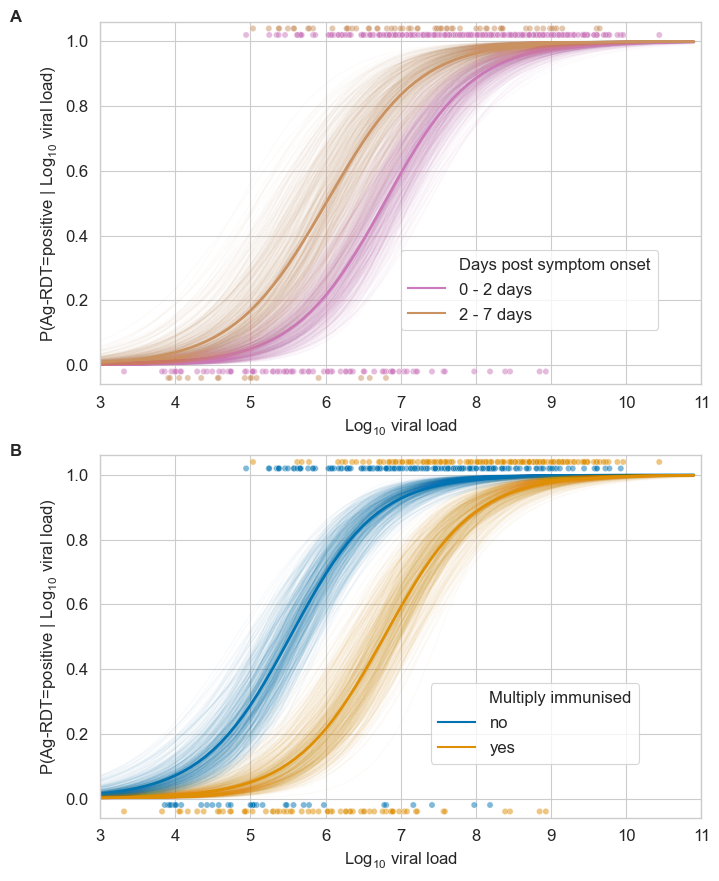

In [22]:
_, ax = plt.subplots(2, 1, figsize=(colWidth*2, colWidth*2.5))
ax1, ax2 = ax.flatten()

spaghettiPlotCategorical(ax1, "binDaysPostOnset", (0, 1), predDictBmb4, dfLogisticBmb4)
spaghettiPlotCategorical(ax2, "immun2YN", (0, 1), predDictBmb4, dfLogisticBmb4, legendLoc=(0.55, 0.15))
plt.tight_layout()

for a in ax1, ax2:
    setFontSize(a, size=fontSizePlot) 
    
annotateWithLetters(ax, size=fontSizePlot, coords=(-0.15, 1))

plt.savefig(f"{plotDir}/Figure5.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/Figure5.pdf", dpi=600, bbox_inches="tight")

### Combined forest plots

In [185]:
from matplotlib import gridspec

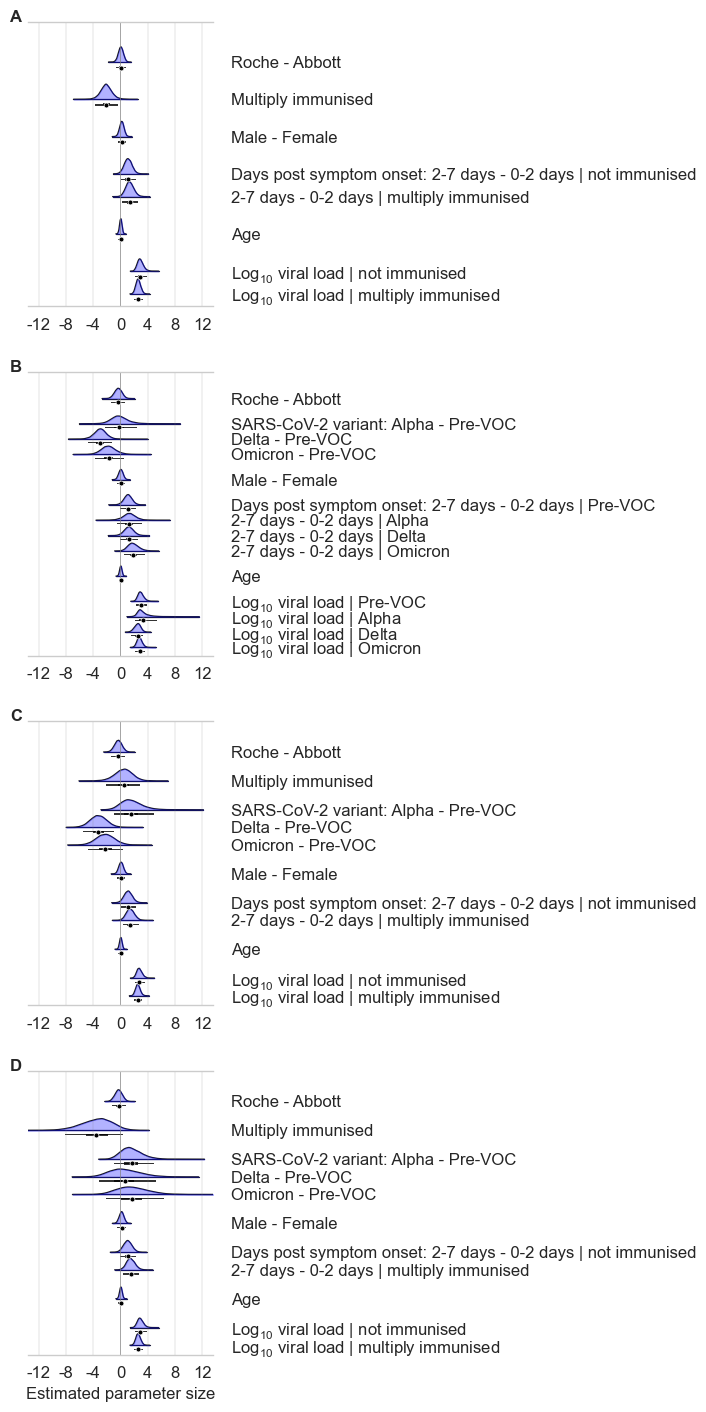

In [70]:
fig, ax = plt.subplots(4, 1, figsize=(colWidth*2, colWidth*4))

varNames1=("testDevice", "immun2YN", "gender", "daysImmun2YN", "zAge", "zVlImmun2YN")
ax[0] = ridgeForestPlot(iDataBmb4, varNames=varNames1, figsize=(colWidth*2, colWidth*1), xlim=(-13.5, 13.5),
                        ax=ax[0], fontsize=fontSizePlot)

varNames2=("testDevice", "variant", "gender", "daysVariant", "zAge", "zVlVariant")
ax[1] = ridgeForestPlot(iDataBmb1, varNames=varNames2, figsize=(colWidth*2, colWidth*1), xlim=(-13.5, 13.5),
                        ax=ax[1], fontsize=fontSizePlot)

varNames3=("testDevice", "immun2YN", "variant", "gender", "daysImmun2YN", "zAge", "zVlImmun2YN")
ax[2] = ridgeForestPlot(iDataBmb2, varNames=varNames3, figsize=(colWidth*2, colWidth*1), xlim=(-13.5, 13.5),
                        ax=ax[2], fontsize=fontSizePlot)

varNames4=("testDevice", "immun2YN", "variant", "gender", "daysImmun2YN", "zAge", "zVlImmun2YN")
ax[3] = ridgeForestPlot(iDataBmb3, varNames=varNames4, figsize=(colWidth*2, colWidth*1), xlim=(-13.5, 13.5),
                        ax=ax[3], fontsize=fontSizePlot)

for a in ax[:-1]:
    a.set_xlabel("")

annotateWithLetters(ax, size=fontSizePlot, coords=(-0.1, 1))

plt.savefig(f"{plotDir}/FigureA3.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA3.pdf", dpi=600, bbox_inches="tight")

# Specificity

In [187]:
n=1000
newData = pd.DataFrame({"samplingMonth2": np.concatenate(list(np.repeat(months, n) for months in 
                        order.samplingMonth2))})
model, iData = sampleAgrdtSpec(dfAllInd, var="samplingMonth2", cats=sorted(dfAllInd.samplingMonth2.unique()),
                               newData=newData, target_accept=0.98)

Modeling the probability that agrdt==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|samplingMonth2_sigma, 1|samplingMonth2_offset]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 198 seconds.


In [188]:
statsDictSpec = defaultdict(lambda: defaultdict(dict))
for samplingMonth2 in order.samplingMonth2:
    idx = newData.index[newData.samplingMonth2==samplingMonth2].tolist()
    samples = iData.posterior.agrdt_mean.stack(sample=("chain", "draw"))[idx].values.flatten()
    mean = np.mean(samples)
    hdi = az.hdi(samples, 0.94)
    statsDictSpec["samplingMonth2"][samplingMonth2]["mean"] = mean
    statsDictSpec["samplingMonth2"][samplingMonth2]["hdi"] = hdi

In [189]:
for samplingMonth2 in order.samplingMonth2:
    print(abbrvDictPaper["samplingMonth2"][samplingMonth2])
    print(f"Specificity (mean, [94% hdi]): {statsDictSpec['samplingMonth2'][samplingMonth2]['mean']:.3f}, {[statsDictSpec['samplingMonth2'][samplingMonth2]['hdi']]}")
    print()

Dec '20 - Jan '21
Specificity (mean, [94% hdi]): 0.999, [array([0.99843165, 0.99996026])]

Feb '21 - March '21
Specificity (mean, [94% hdi]): 0.998, [array([0.99628778, 0.99973265])]

April '21 - May '21
Specificity (mean, [94% hdi]): 0.998, [array([0.99650937, 0.99993231])]

June '21 - July '21
Specificity (mean, [94% hdi]): 0.998, [array([0.99582619, 0.99999999])]

Aug '21 - Sep '21
Specificity (mean, [94% hdi]): 0.998, [array([0.99462203, 0.99994133])]

Oct '21 - Nov '21
Specificity (mean, [94% hdi]): 0.999, [array([0.99681588, 0.99993952])]

Dec '21 - Jan '22
Specificity (mean, [94% hdi]): 0.999, [array([0.9972584, 1.       ])]

Feb '22
Specificity (mean, [94% hdi]): 0.996, [array([0.98839628, 0.99993807])]

